# [ EXPLORATION ] 4. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

✅캐글 경진대회에 직접 참가해 대회의 규칙과 분위기를 살펴보는 것부터, 머신러닝을 활용해서 모델을 학습시킨 뒤 제출하고 내 랭킹을 확인해보는 것까지, 캐글 경진대회를 위한 전과정을 체험해본다.

---
### - 📖목차
* ✔️4-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!
* ✔️시도해 볼 수 있는 방법(넘버링 R)
    1. 기존 데이터 피처 모델을 보다 잘 표현할 수 있는 형태로 정리(피처 엔지니어링)
    <br>1-1. [부록] 과연 어디의 집값을 다루는 것인가?
    <br>1-2. 모델의 성능을 저하시키는 '아웃라이어' 값은 어디에 있을까?
    2. 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도 후 최적의 조합 찾기
    3. 세가지 이상의 다양한 모델에 하이퍼 파라미터 튜닝
    4. Baseline 커널에서 활용된 블렌딩 방법 활용(앙상블 모델 2, 3, 4, 6 - 5가지 버전 실험)
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



In [ ]:
# 파일 로드
from google.colab import files
files.upload()

## ✔️4-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!
-----
#### 2. 데이터 가져오기

In [3]:
# 라이브러리, 모듈 불러오기
import pandas as pd
import numpy as np
import missingno as msno # 결측치를 찾기 위해 가져온 missingno

import os
from os.path import join

# 시각화 도구
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 모델 모듈
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [4]:
# 에러 무시
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 데이터 로드
train = pd.read_csv('train.csv') #원래는 따로 경로를 잡아주는데 코랩이라 다이렉트로 파일 들고옴
test = pd.read_csv('test.csv')

In [14]:
# 데이터 크기
data = pd.read_csv('train.csv')
sub = pd.read_csv('test.csv')
print('- train data dim : {}'.format(data.shape))
print('- sub data dim : {}'.format(sub.shape))

- train data dim : (15035, 21)
- sub data dim : (6468, 20)


In [ ]:
# 데이터의 columns 값 확인하기 (총 22개)
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

##### - 각각의 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

출처:

https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/data

#### 3. 데이터 이해하기(데이터 전처리)

In [ ]:
data.head() # 데이터 프레임으로 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


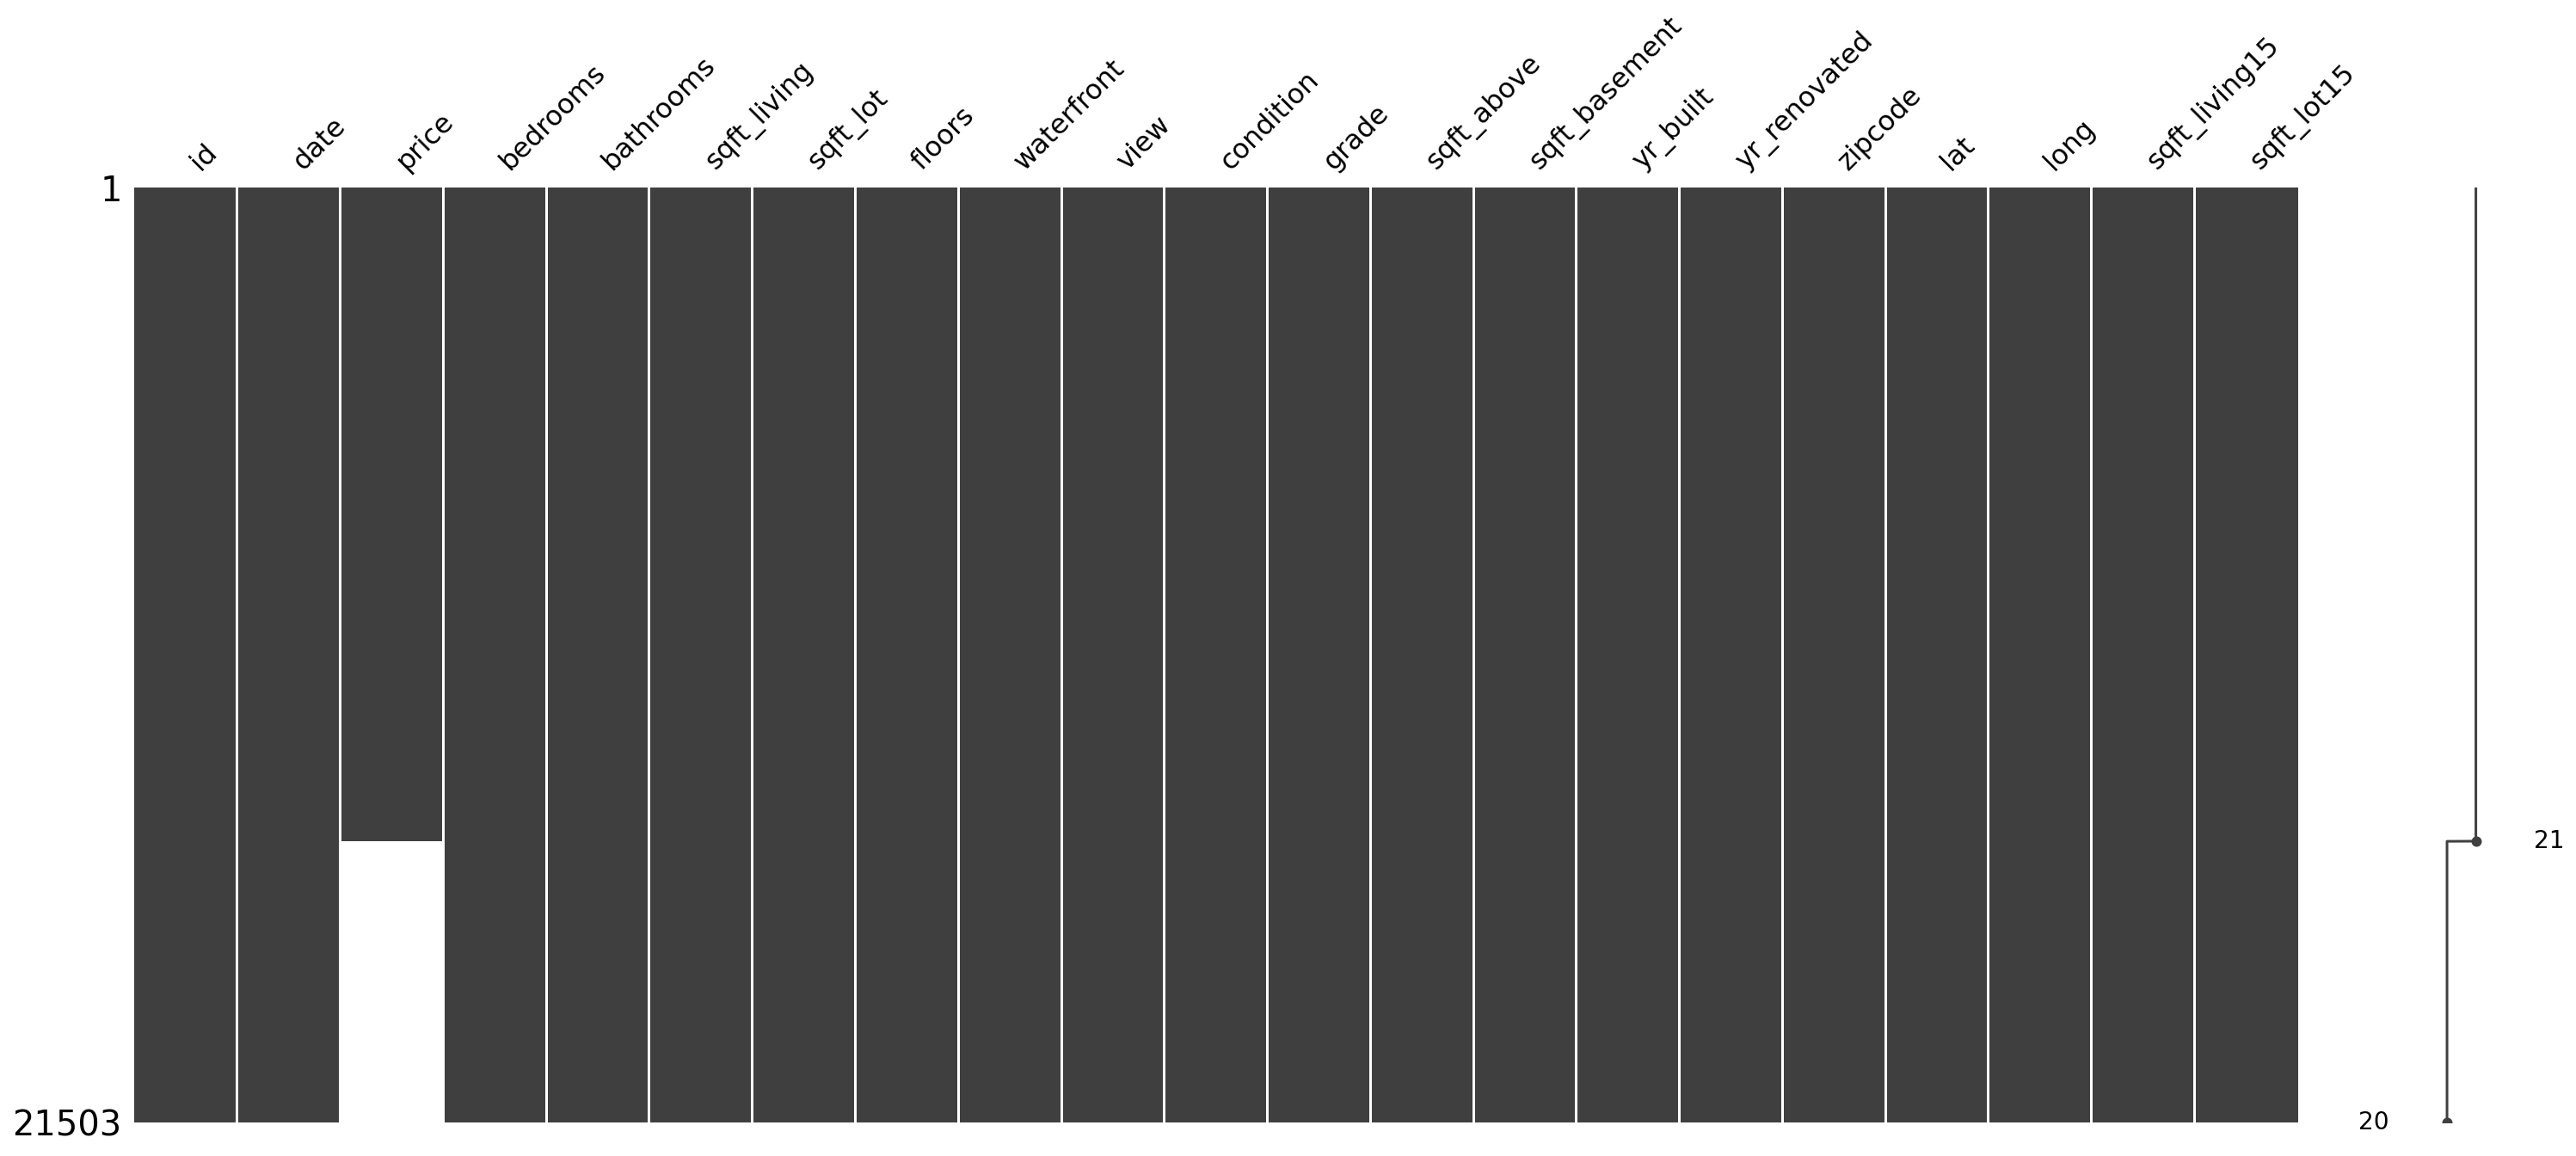

In [ ]:
# price를 제거하기 전인데 데이터가 일정 비어있는 것을 확인
msno.matrix(data)

In [15]:
# y축으로 price를 옮기고 다시 columns를 체크
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


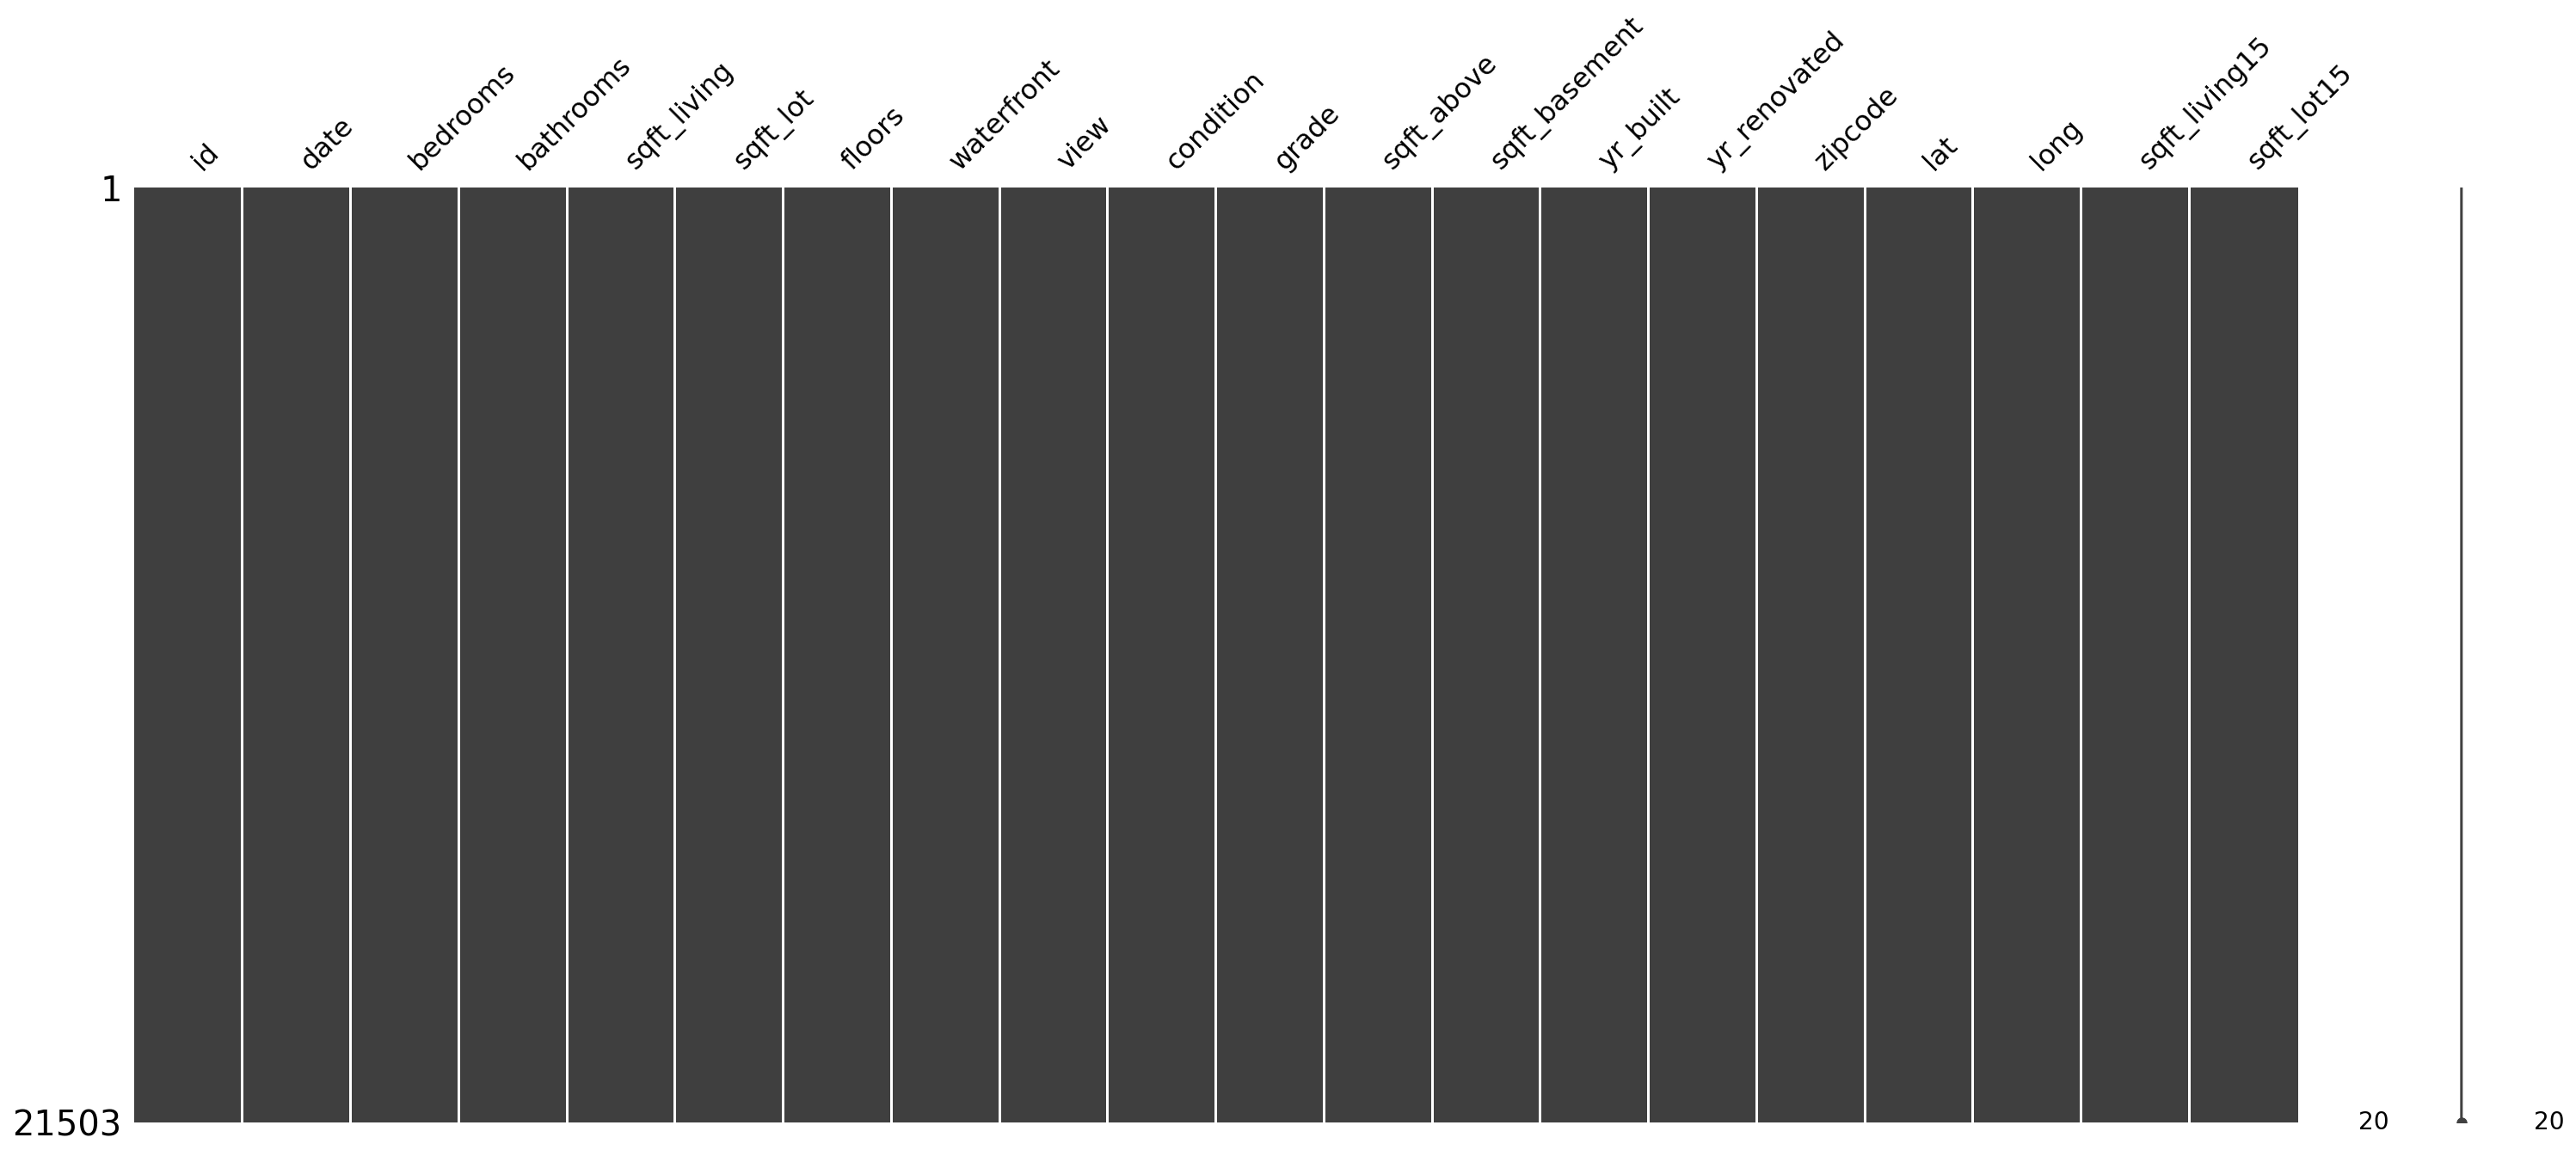

In [ ]:
# 다른 결측값은 없는지 다시 확인
msno.matrix(data)

In [16]:
# 학습 데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0) # 전체 데이터에 대해 탐색해보기 위해 concat으로 합침

print(len(data))

21503


In [ ]:
# id 컬럼이 결측치인지 확인
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [ ]:
# 결측치인 데이터만 뽑아내기
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [ ]:
# 결측치인 데이터의 개수를 카운드
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


* 따로 빠지는 데이터가 없는 것을 확인(사실 이 뒤로 데이터 프레임 체크가 추가로 있긴 한데 다 빈칸으로 나오기 때문에 생략했습니다.)

In [17]:
# id, data 변수 정리
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [18]:
# 연, 월, 일 데이터로 이용하기 위해 000000의 6자리 까지만 잘라내기
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


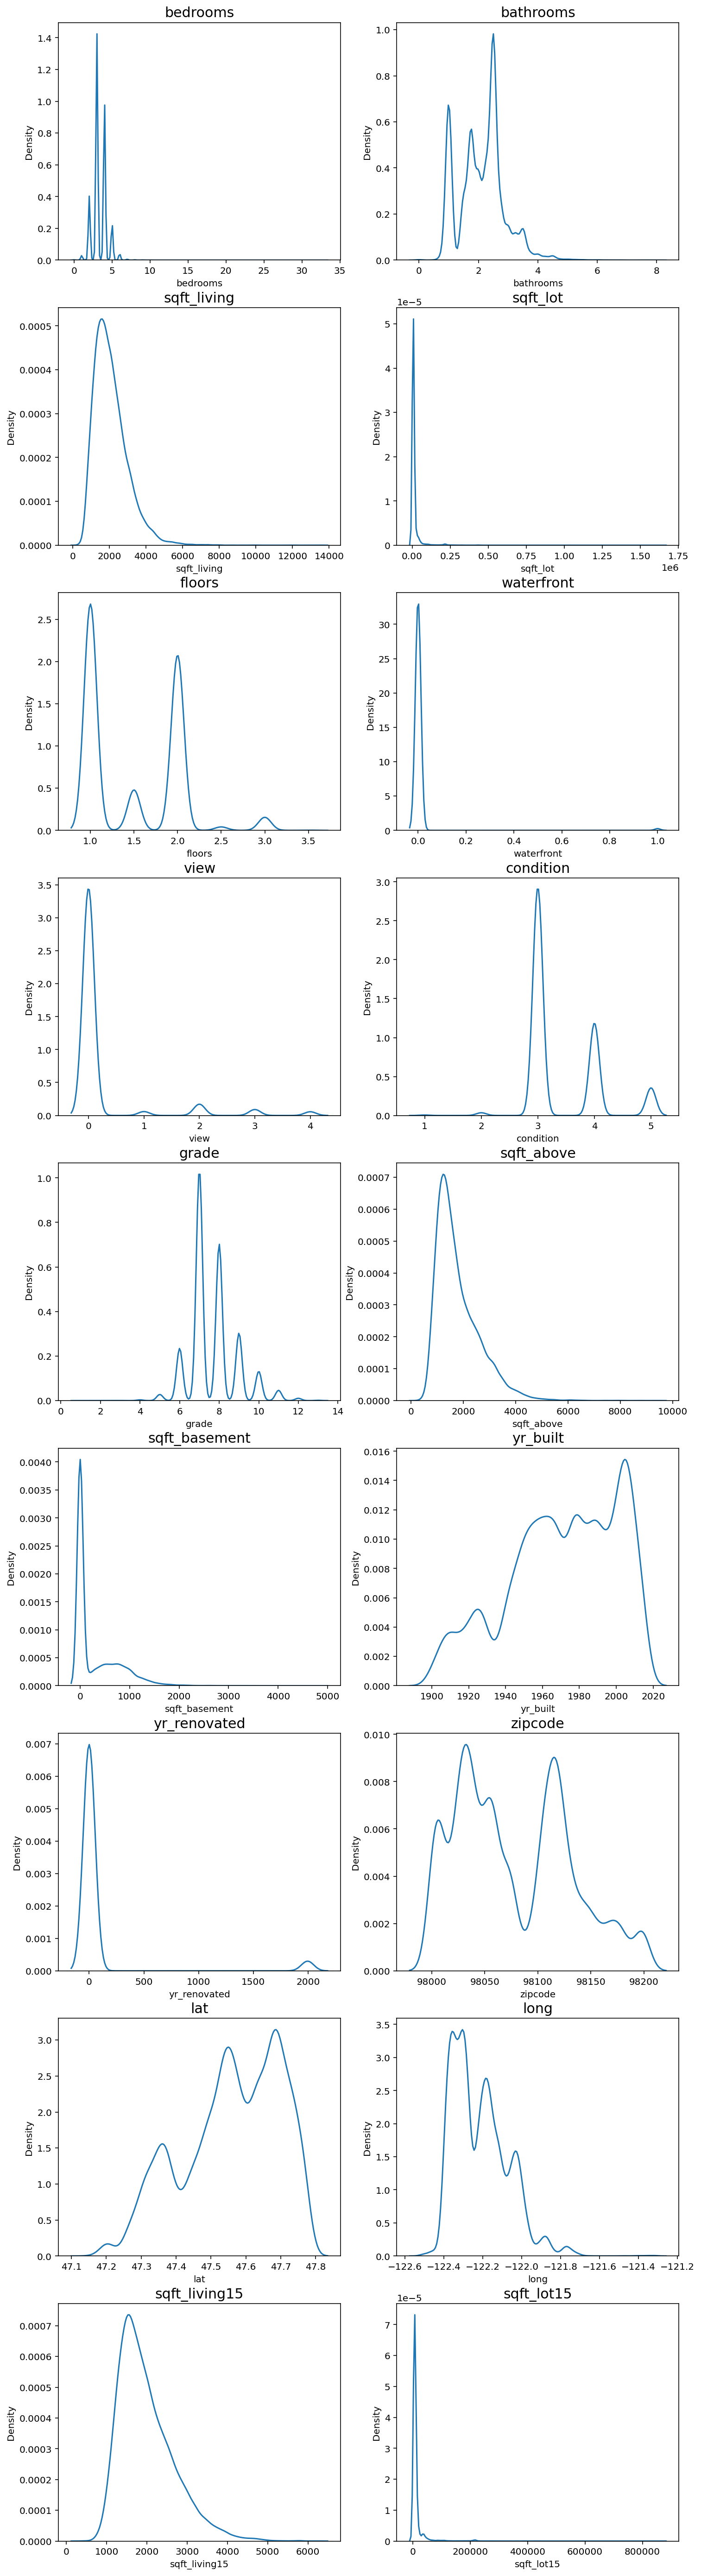

In [ ]:
# id 변수(count==0인 경우)는 제외하고 분포를 확인.
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 보기 편하게 figsize의 x값을 조절 

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [ ]:
# 로그변환으로 치우침을 최소화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

* 전부 하는게 아니라 '너무 치우쳐 있는 데이터에 한해서' 필요한 경우에만 로그로 변환한다는 점에 유의한다. 어차피 나중에 다시 로그를 벗겨내고 원 데이터로 돌아와야 하기 때문에...

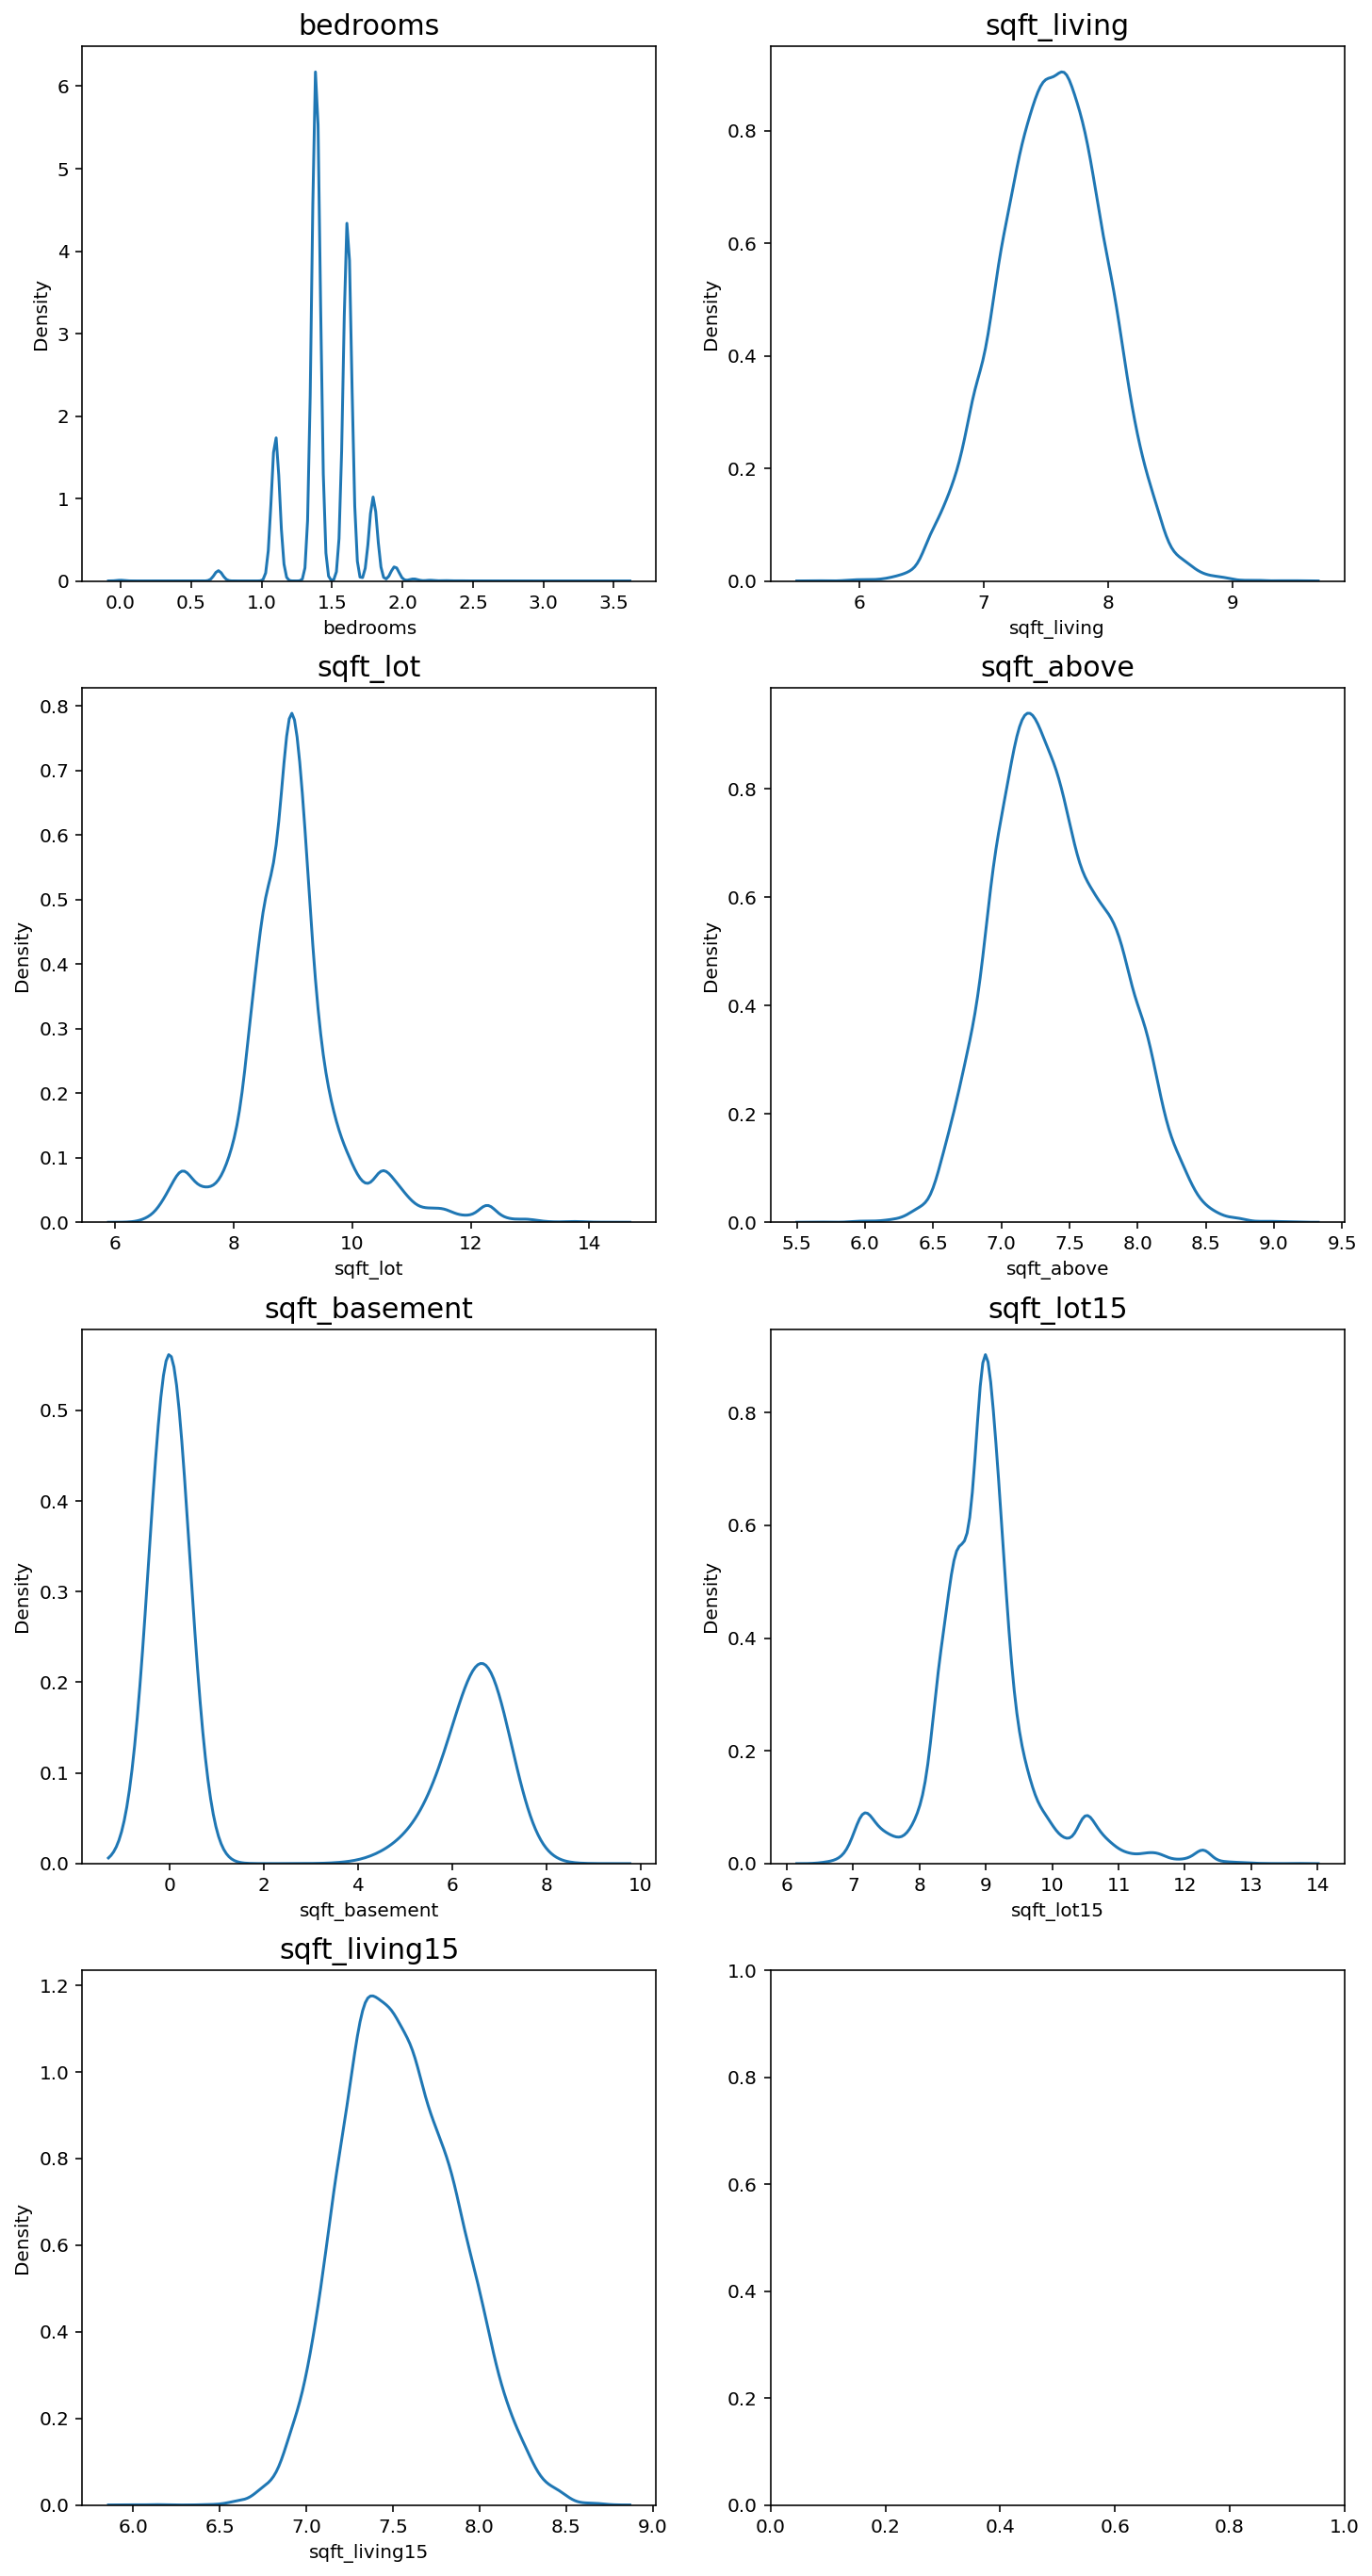

In [ ]:
# 로그로 변환된 분포를 다시 확인
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

* 맨 마지막 요소가 아무것도 안뜨는 걸 보고 버그가 아닌가 한참 고민했는데, LMS상에서도 같게 나오기 때문에 그 원인이 아닌것 같다고 판단했다. 따로 로그를 씌우면 값이 사라지는 점에 대해서 찾아봤었는데 아무래도 마이너스라 로그를 씌웠을 때 따로 나오지 않는게 아닌가 추측했다.

In [ ]:
# [ :train_len ]은 x에 저장, [ train_len: ]은 sub 변수에 저장
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


#### 4. 모델 설계

In [ ]:
# 블렌딩 모델을 제작(Average Blending)
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

* 모델은 gboost, xgboost, lightgbm 선택

In [ ]:
# 교차 검증을 위한 함수 생성
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
[14:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


* cross_val_score()의 경우 1에 가까울 수록 잘 학습되었다는 것을 뜻하는데, 여기서는 각각의 모델이 평균 0.8 후반대의 약 0.9 정도의 성능을 보여줬기 때문에 잘 학습됬다는 것을 확인할 수 있었다.

In [ ]:
# 각 모델에 대한 예측결과 평균을 내는 함수를 생성
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
# 위의 함수를 써서 도출한 값을 y_pred에 저장한뒤에 확인
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [ ]:
# 캐글에 재출해야하는 파일이 CSV 파일이므로 일단 sample 파일 먼저 확인
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
# 확인한 샘플 파일의 폼에 맞게 id와 price로 구성된 데이터 프레임을 생성한 뒤에 확인
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [ ]:
# 해당 데이터프레임을 submission.csv 파일로 저장하기(index는 생략하기로 한다)
result.to_csv('submission.csv', index=False)

In [ ]:
!ls #submission.csv로 저장된 것을 확인

sample_data  submission.csv  test.csv  train.csv


* 다 끝낸 뒤에 여기서 submmision.csv 파일을 저장한 뒤에 캐글에 제출해보기로 한다.

#### 5. 캐글에 첫 결과 제출하기

![20220505172048](https://user-images.githubusercontent.com/100528803/166886404-d16eac93-1a26-4d87-9ad2-2ed5dacdb333.png)

* LMS 때와는 제출 방식이 조금 틀려져서 이 대회에 제출하려면 따로 private 절차가 필요했다.(사실 이것 때문에 아예 제출할 수 없는건지 조금 헤멨다.....) 간단한 절차 후에 제출한 스코어는 [ 120031 ]이었고, 루브릭에서 제시한 [ 110000 ]보다는 1만 차이가 나기 때문에 어떻게하면 좀더 차이를 좁힐 수 있을까 쭉 과정을 더 따라가 보기로 했다.

## ✔️시도해 볼 수 있는 방법
-----
### R-1. 기존 데이터 피처 모델을 보다 잘 표현할 수 있는 형태로 정리(피처 엔지니어링)
#### 1. 다시 한 번, 내 입맛대로 데이터 준비하기

> 기본사항은 끝났으니, 이제는 제대로 데이터를 분석하면서 데이터를 다시 뜯어본 뒤에 리더보드 11만 안으로 들어보기로 한다.

In [76]:
# 데이터 다시 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [77]:
# 데이터 크기
data = pd.read_csv('train.csv')
sub = pd.read_csv('test.csv')
print('- train data dim : {}'.format(data.shape))
print('- sub data dim : {}'.format(sub.shape))

- train data dim : (15035, 21)
- sub data dim : (6468, 20)


In [ ]:
train.head() #train의 데이터를 데이터 프레임으로 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [78]:
# 앞자리 6자리까지만 잘라서 yymmdd 형식으로 만들기
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [79]:
# 학습 데이터에서 라벨 제거(price는 y라는 변수로 옮겨 저장)
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [80]:
# 연, 월, 일 데이터로 이용하기 위해 000000의 6자리 까지만 잘라내기
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


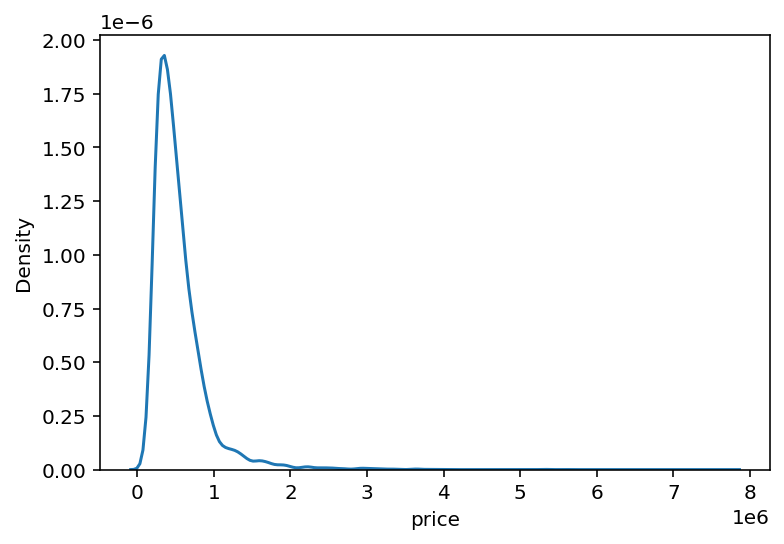

In [ ]:
# 타겟 데이터인 y의 분포 확인
# seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인
sns.kdeplot(y)
plt.show()

In [81]:
# 치우쳐 있는걸 확인하고 y에 로그를 씌워서 적용한다.
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

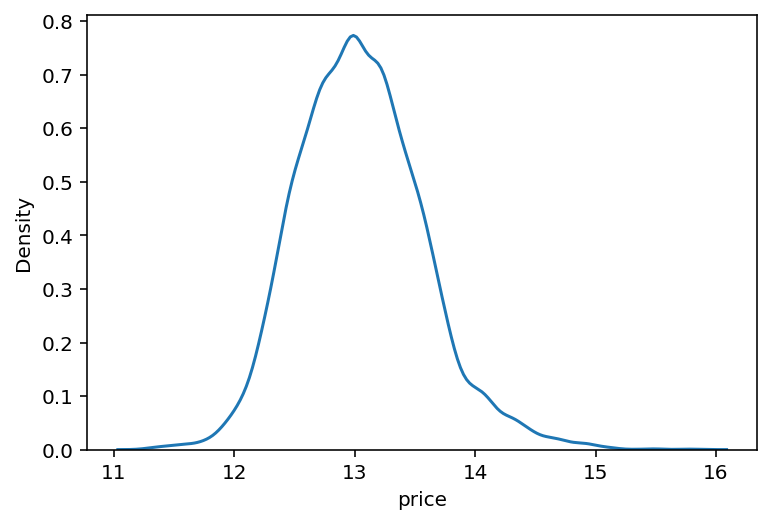

In [ ]:
# 다시 정규분포가 고르게 나뉘어진 것을 확인
sns.kdeplot(y)
plt.show()

In [ ]:
train.info() #train 데이터에 null 값이 존재하는지, 타입이 뭔지를 같이 체크

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

### 1-1. [부록]과연 어디의 집값을 다루는 것인가?

* 사실 이 데이터를 다루면서 가장 궁금했던 건 '이 데이터는 어느 지역의 집값'인지, '어떤 요인들로 인해 집값이 좌우되는지'의 여부였다. 따라서 이를 통해 캐글에 재출한 분들의 코드들을 보고 빌려서 어떤 데이터인지를 먼저 제대로 체크해보고 싶어 따로 섹션을 나눠봤다.

Text(0.5, 1.0, '- 2019 2nd ML month with KaKR -')

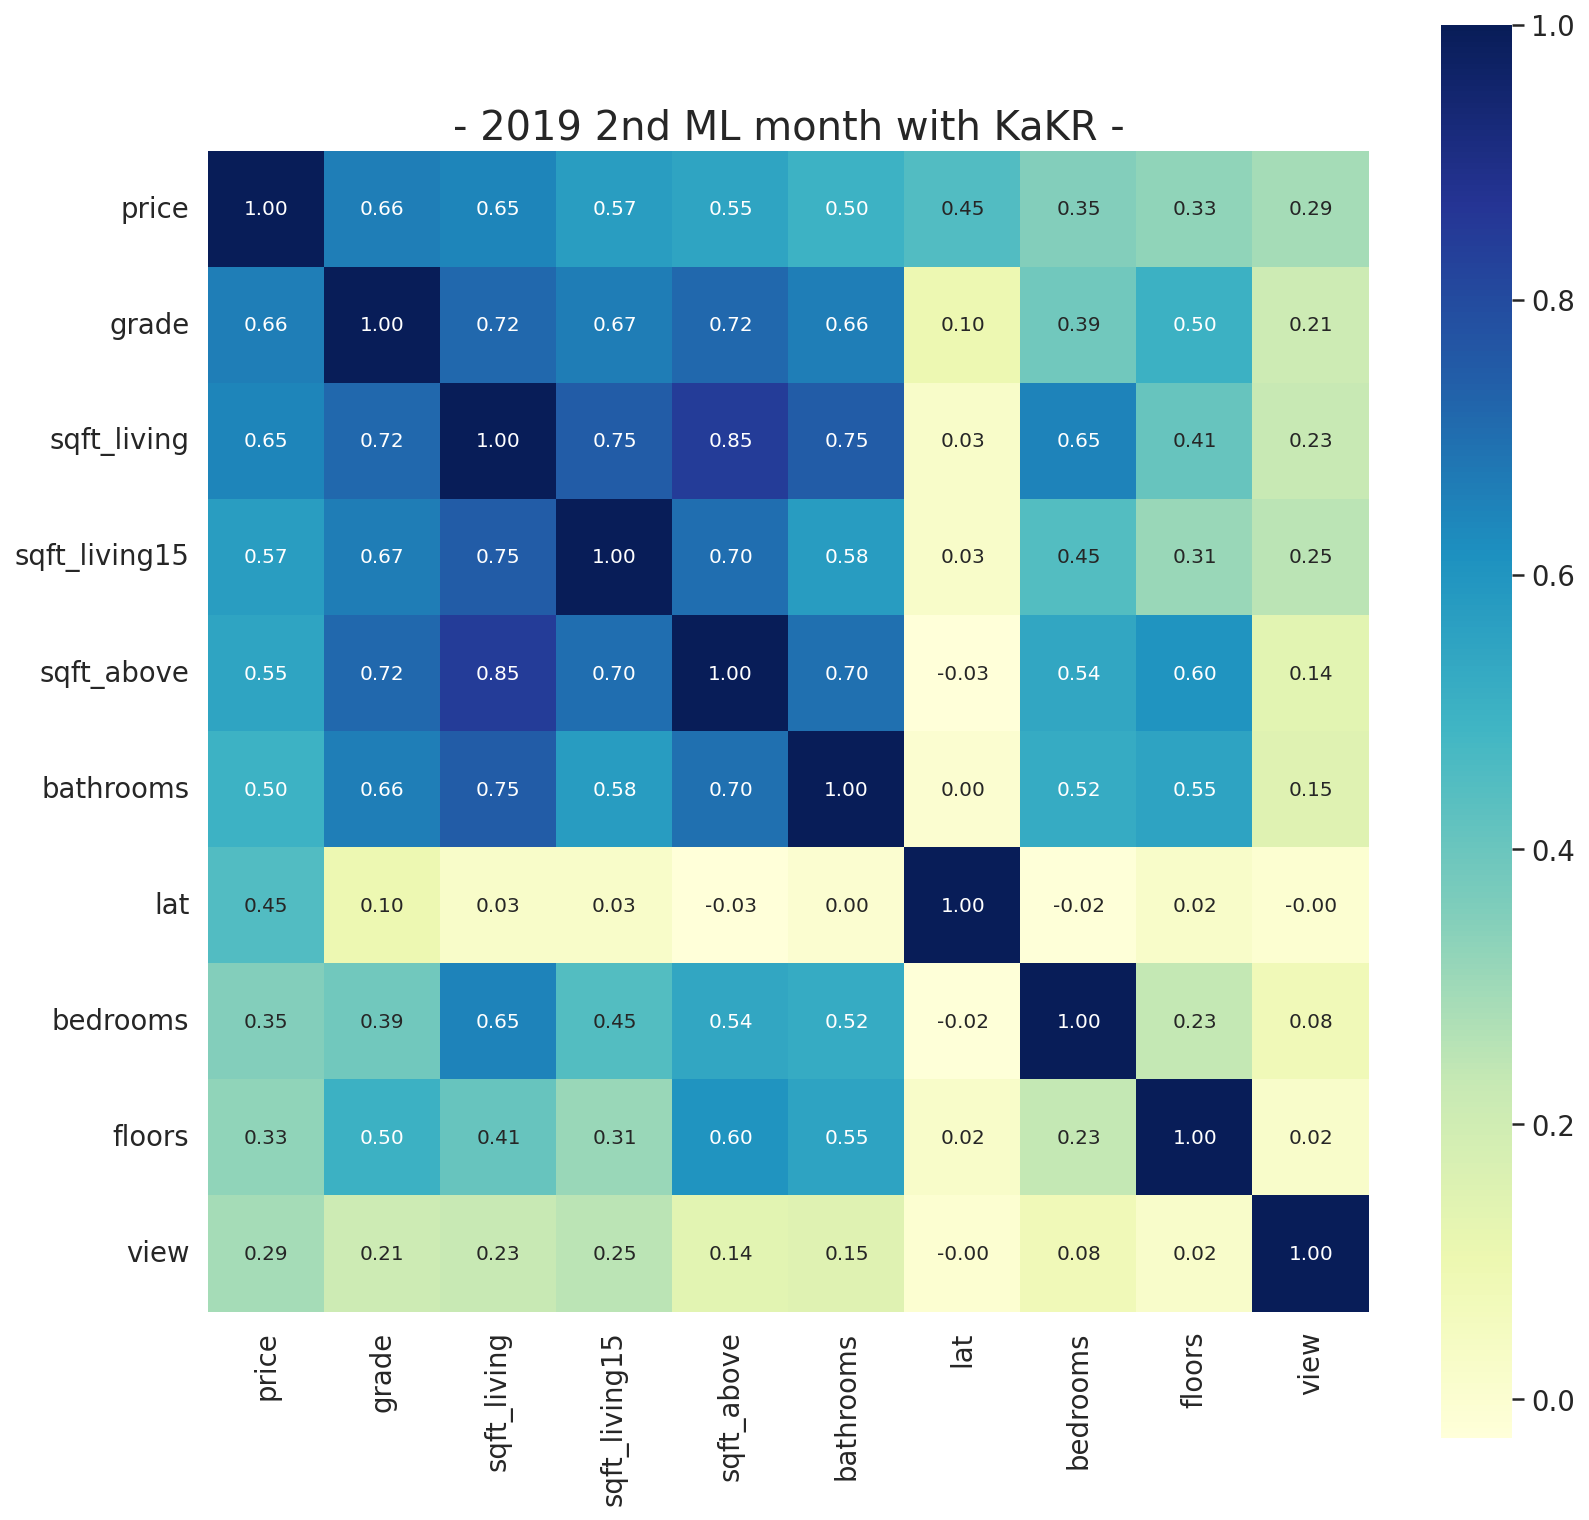

In [ ]:
# Price 대비 어떤 요소들이 집값에 영향을 크게 미치는지 살펴보기

# 모듈 로드
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Heatmap을 위한 그래프 설정
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] 
plt.figure(figsize=(13,13))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,cmap="YlGnBu", 
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.title('- 2019 2nd ML month with KaKR -', fontsize=20)

* 집의 가격(price)와의 상관계수가 높은 순서

1. 집의 등급(grade)
2. 주거 공간의 크기(sqft_living, sqft_living15(2015년 기준)
3. 전체 크기(sqft_above)
4. 화장실(bathrooms)
5. 위도(lat)

- 의아했던 게 화장실 다음에 희안하게 뷰(view)가 아니라 위도가 뜬금없이 상위권에 올라있었던 점이었는데, 이건 나 말고도 다른 분들의 궁금증도 함께 있었던 모양이다. 이 궁금증에 대한 답변은 다른 캐글의 의견 속에서 찾을 수 있었다.

![20220505182046](https://user-images.githubusercontent.com/100528803/166896045-e758708d-3504-4c4d-8bbe-ed3bedbde913.png)

![20220505182100](https://user-images.githubusercontent.com/100528803/166896103-bd1f3cbc-9774-458c-b262-d313febc118f.png)

* 해당 링크에 나온 데이터 상에서의 지역 표시들을 확인한 결과, 실제로 위도상에서 북쪽에 있는 집들을 선호하는 경향이 많다는 걸 위치상으로 체크해볼 수 있었다. 

여기까지 보고 나니 현재 데이터에 나온 집들은 어느 위치에 정확히 위치해 있었는지 궁금해져서 다른 분들의 캐글을 찾아봤다.( 이분들의 사이트는 아래 레퍼런스로 첨부합니다)

In [ ]:
# folium 라이브러리를 이용해서 지도내에서의 위치를 잡아내기(역시 캐글 코드입니다)

# 모듈 가져오기
import folium
from folium import plugins

# lat, long을 이용해서 어느 지역에 얼만큼의 집이 존재하는지 크게 위치를 잡아내기
houses_map = folium.Map(location = [train['lat'].mean(), train['long'].mean()], zoom_start = 10)
lat_long_data = train[['lat', 'long']].values.tolist()
h_cluster = folium.plugins.FastMarkerCluster(lat_long_data).add_to(houses_map)

houses_map

* ' Make this Notebook Trusted to load map: File -> Trust Notebook '문제로 위의 코드로 나오는 시각화를 이미지로 대체합니다.

![20220506005219](https://user-images.githubusercontent.com/100528803/166963143-10d4c4fd-322a-4a9b-9ccb-4442551e7f98.png)

* 이 데이터의 정체는 미국 워싱턴의 시애틀과 벨뷰 일대의 집 가격들을 모아둔 거였다. 주로 시애틀 근처의 집들이 밀집되어 있음을 확인했고, 앞서 위에서 본 데이터(위도와 집값이 왜 상관이 있는지)를 조합해보면 위치에 따라 왜 집값이 달라질 수 있는지를 지역상으로 판단해 볼 수 있었다.


![20220505185020](https://user-images.githubusercontent.com/100528803/166900171-bb20d565-2ab4-4ba6-9c0a-b078053ea907.png)

* 위 캐글 유저 분께서 보여준 데이터를 이용해서 정확히 어디 집값이 가장 높은가를 색으로 표시해줬는데(사실 코드를 다 들고 돌려보긴 했는데, 나중에 folium을 이용해 내가 직접 구현해보고 싶어서 여기 첨부하지 않음) 마찬가지로 시애틀과 벨뷰 사이에 물을 끼고 있는 리버뷰가 제일 비쌌음을 시각적으로 볼 수 있었다. 

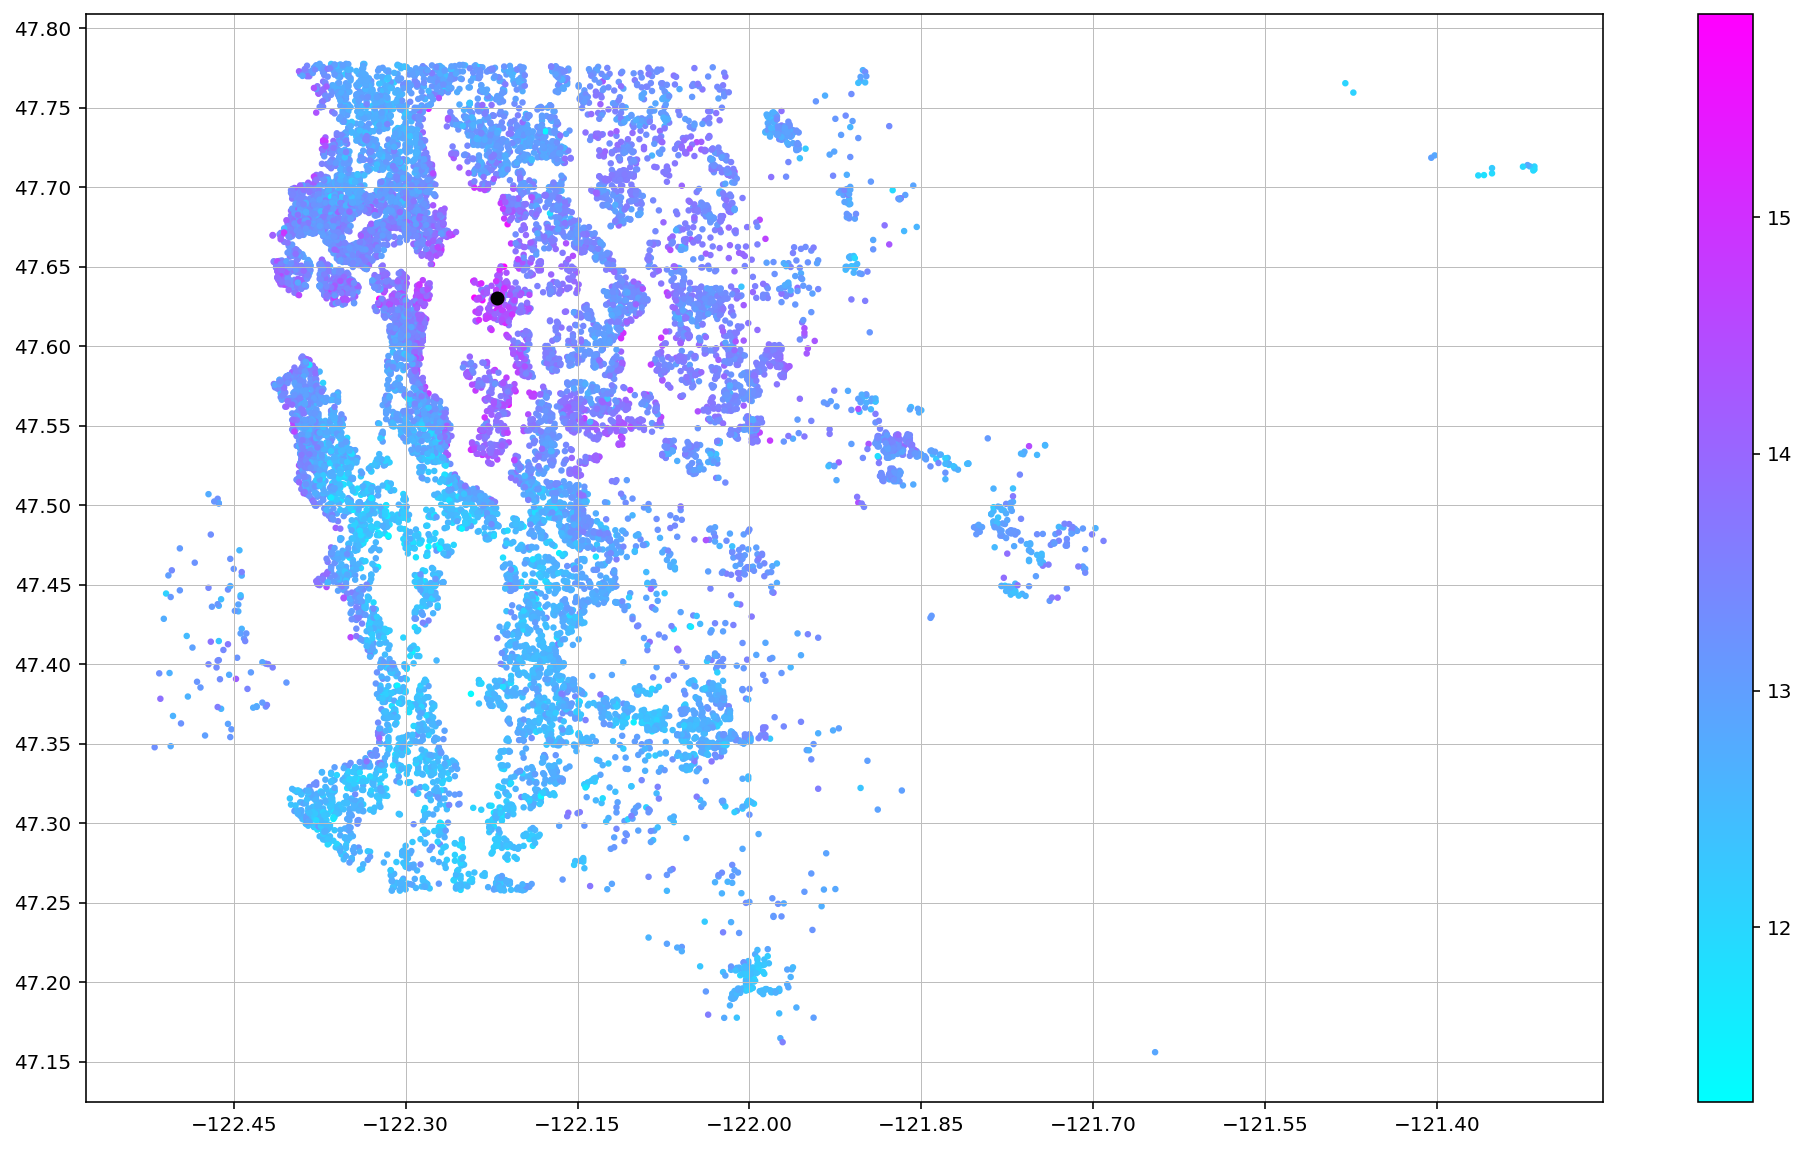

In [42]:
# 데이터 상에서의 집값 분포 확인
plt.figure(figsize=(17,10))

# 산점도로 각각 long, lat으로 위도를, price에 따라 coowarm으로 표기
plt.scatter(data['long'], data['lat'], s=5, c=np.log1p(data['price']), cmap='cool') 
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()

plt.scatter(-122.22, 47.63, color='black') #가격이 가장 높은 지점의 좌표

* 위의 지도를 미루어서 볼 때, 이 데이터에서 위도가 집값에 어떻게 영향을 주는지를 좀더 명확하게 체크해볼 수 있었다. 확실히 가격이 높게 표기되는 보라색 지점들이 줌심부의 리버뷰에 포진되어 있음을 재차 확인할 수 있었다. ( 사실 원래 이 데이터만 보면 이게 대체 뭘 의미하는지 보기 힘들었을 것 같은데, 위의 지도 데이터를 한번 보고나서 보니까 왜 이 데이터가 이런 형샹을 띄고 있는지 단번에 알 수 있었다. )

* 위치에 따라 집값이 달라질 수 있다는 지점까지 확인하고 나서 데이터를 살펴보는데, [ zipcode ]라는게 눈에 띄었다. 이를 위도와 경도랑 같이 묶어서 분류하신 분들이 제법 보여서 찾아보니 '우편번호'라고 되어 있어서 흥미가 돌았다.

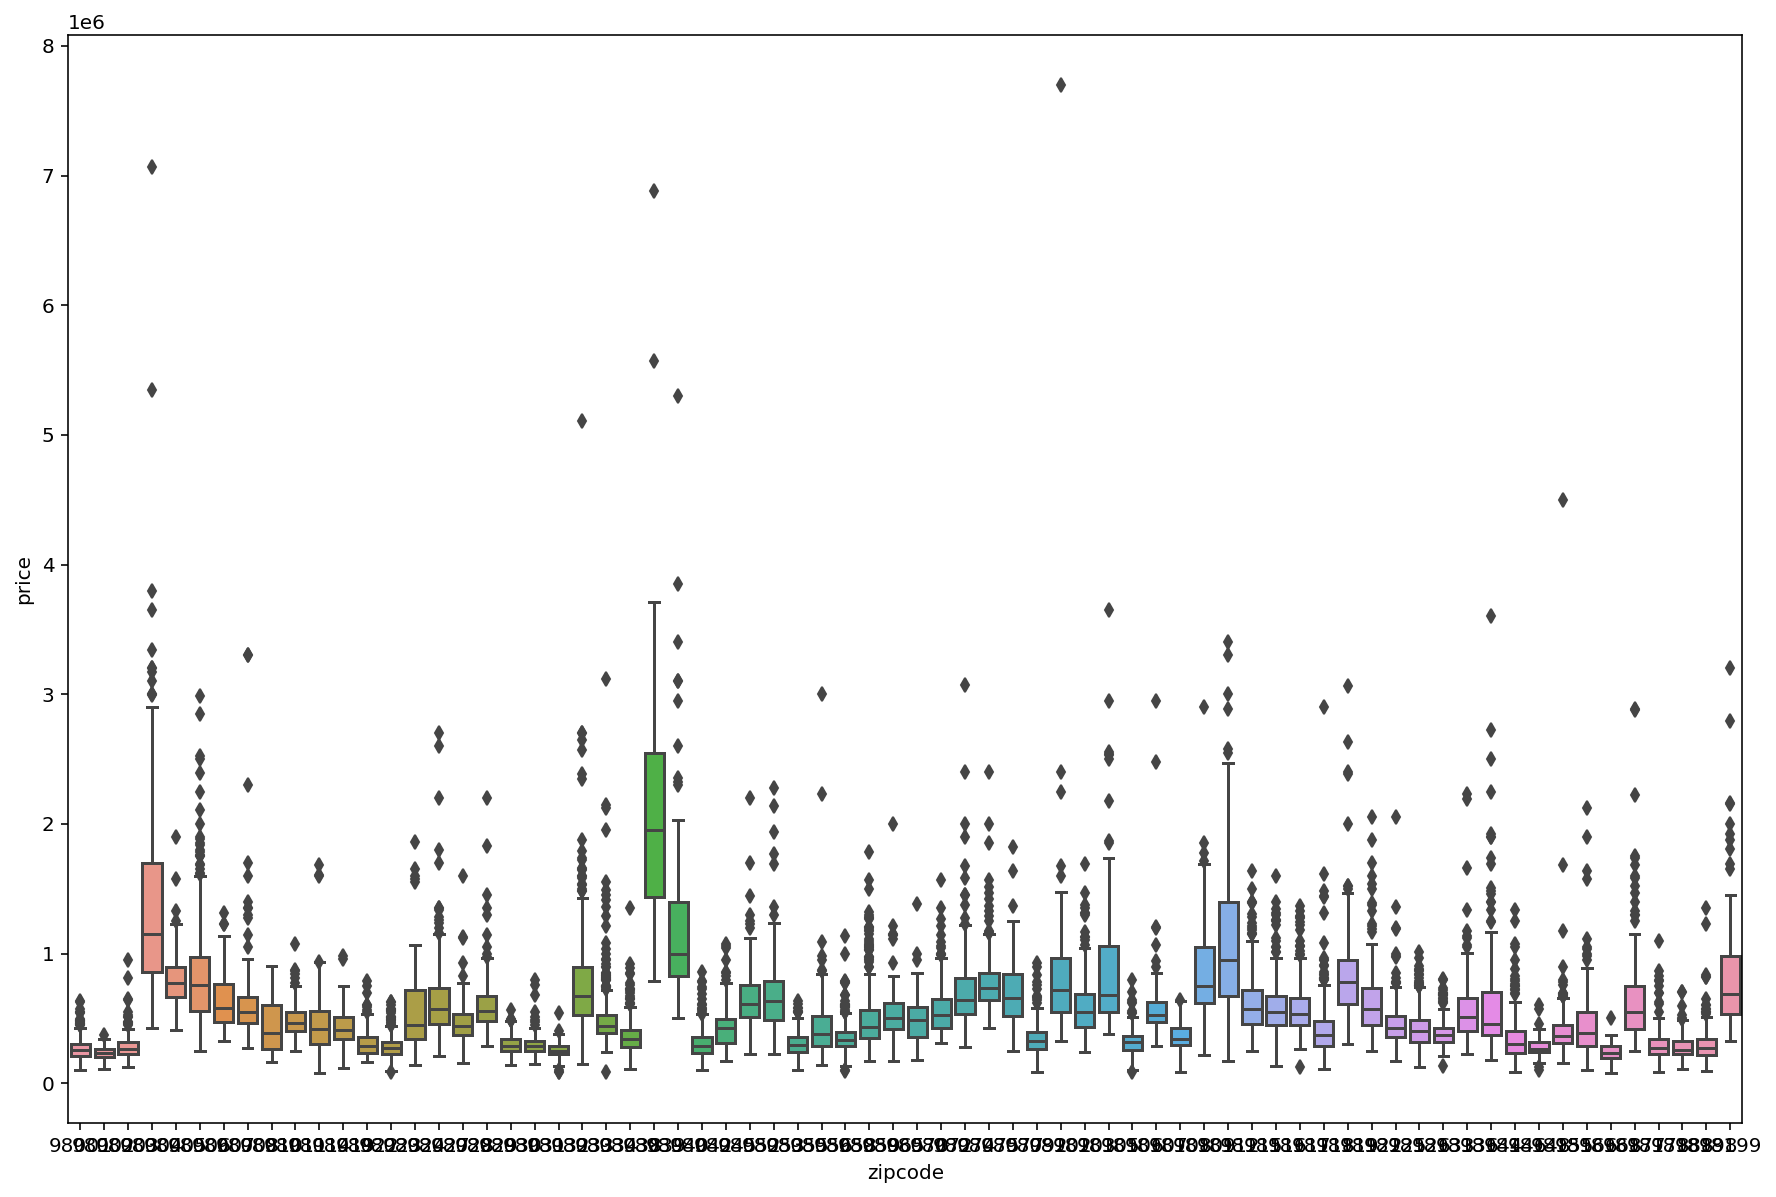

In [59]:
# Zipcode를 이용해서 가격과의 상관관계 표기
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.boxplot(x='zipcode', y='price', data=data)

* 앞서 위치대비 집값과 더불어 우편번호들로 구별된 몇몇 지역의 경우에는 더 가격대가 높게 설정된 것을 확인할 수 있었다. 역시 우리 지역에서의 서울권 강남처럼 적당히 강이 잘 보이는 특정 지역의 집값들이 몰려서 상대적으로 높게 형성되어 있을 수 있겠구나를 우편번호를 통해 짐작할 수 있었다.

![20220505184137](https://user-images.githubusercontent.com/100528803/166901188-118a82d5-e6be-4e3b-ab82-3f9ea02aee1e.png)

* 사실 여기 쓰인 데이터들은 2019년까지가 기준이었기 때문에 현재는 어느 정도인지 궁금해서 뉴스를 찾아봤는데, 최근까지도 미국 전역에서 2위권 안에 들 만큼 비싼 집값을 자랑했다.....(부자 지역이었구나)

### 1-2. 모델의 성능을 저하시키는 '아웃라이어' 값은 어디에 있을까?

* 캐글의 코드들을 쭉 보면서 제일 많이 대두되었던 것 중 하나가 바로 '아웃라이어 값을 어떻게 처리하느냐' 였다. 사실 아웃라이어 값을 아예 제외하는 경우도 있었지만, 대부분의 경우 그냥 표기만 하고 따로 제외시키지 않는 경우가 제법 있어서 이번에는 어디에 아웃라이어 값이 있는지만 체크해보려고 한다.

In [61]:
# price와 가장 연계가 있는 순서대로 column(feature)을 뽑아내기
cor = data.corr(method='spearman')
cor["price"].nlargest(n=20).index

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'lat', 'bedrooms', 'floors', 'view', 'sqft_basement',
       'waterfront', 'yr_renovated', 'yr_built', 'sqft_lot', 'long',
       'sqft_lot15', 'id', 'condition', 'zipcode'],
      dtype='object')

* 앞서 히트맵에서와 봤던 것과 마찬가지로 grade, sqft_living, sqft_living15, sqft_above, bathrooms, lot, bedrooms 순으로 나왔다.

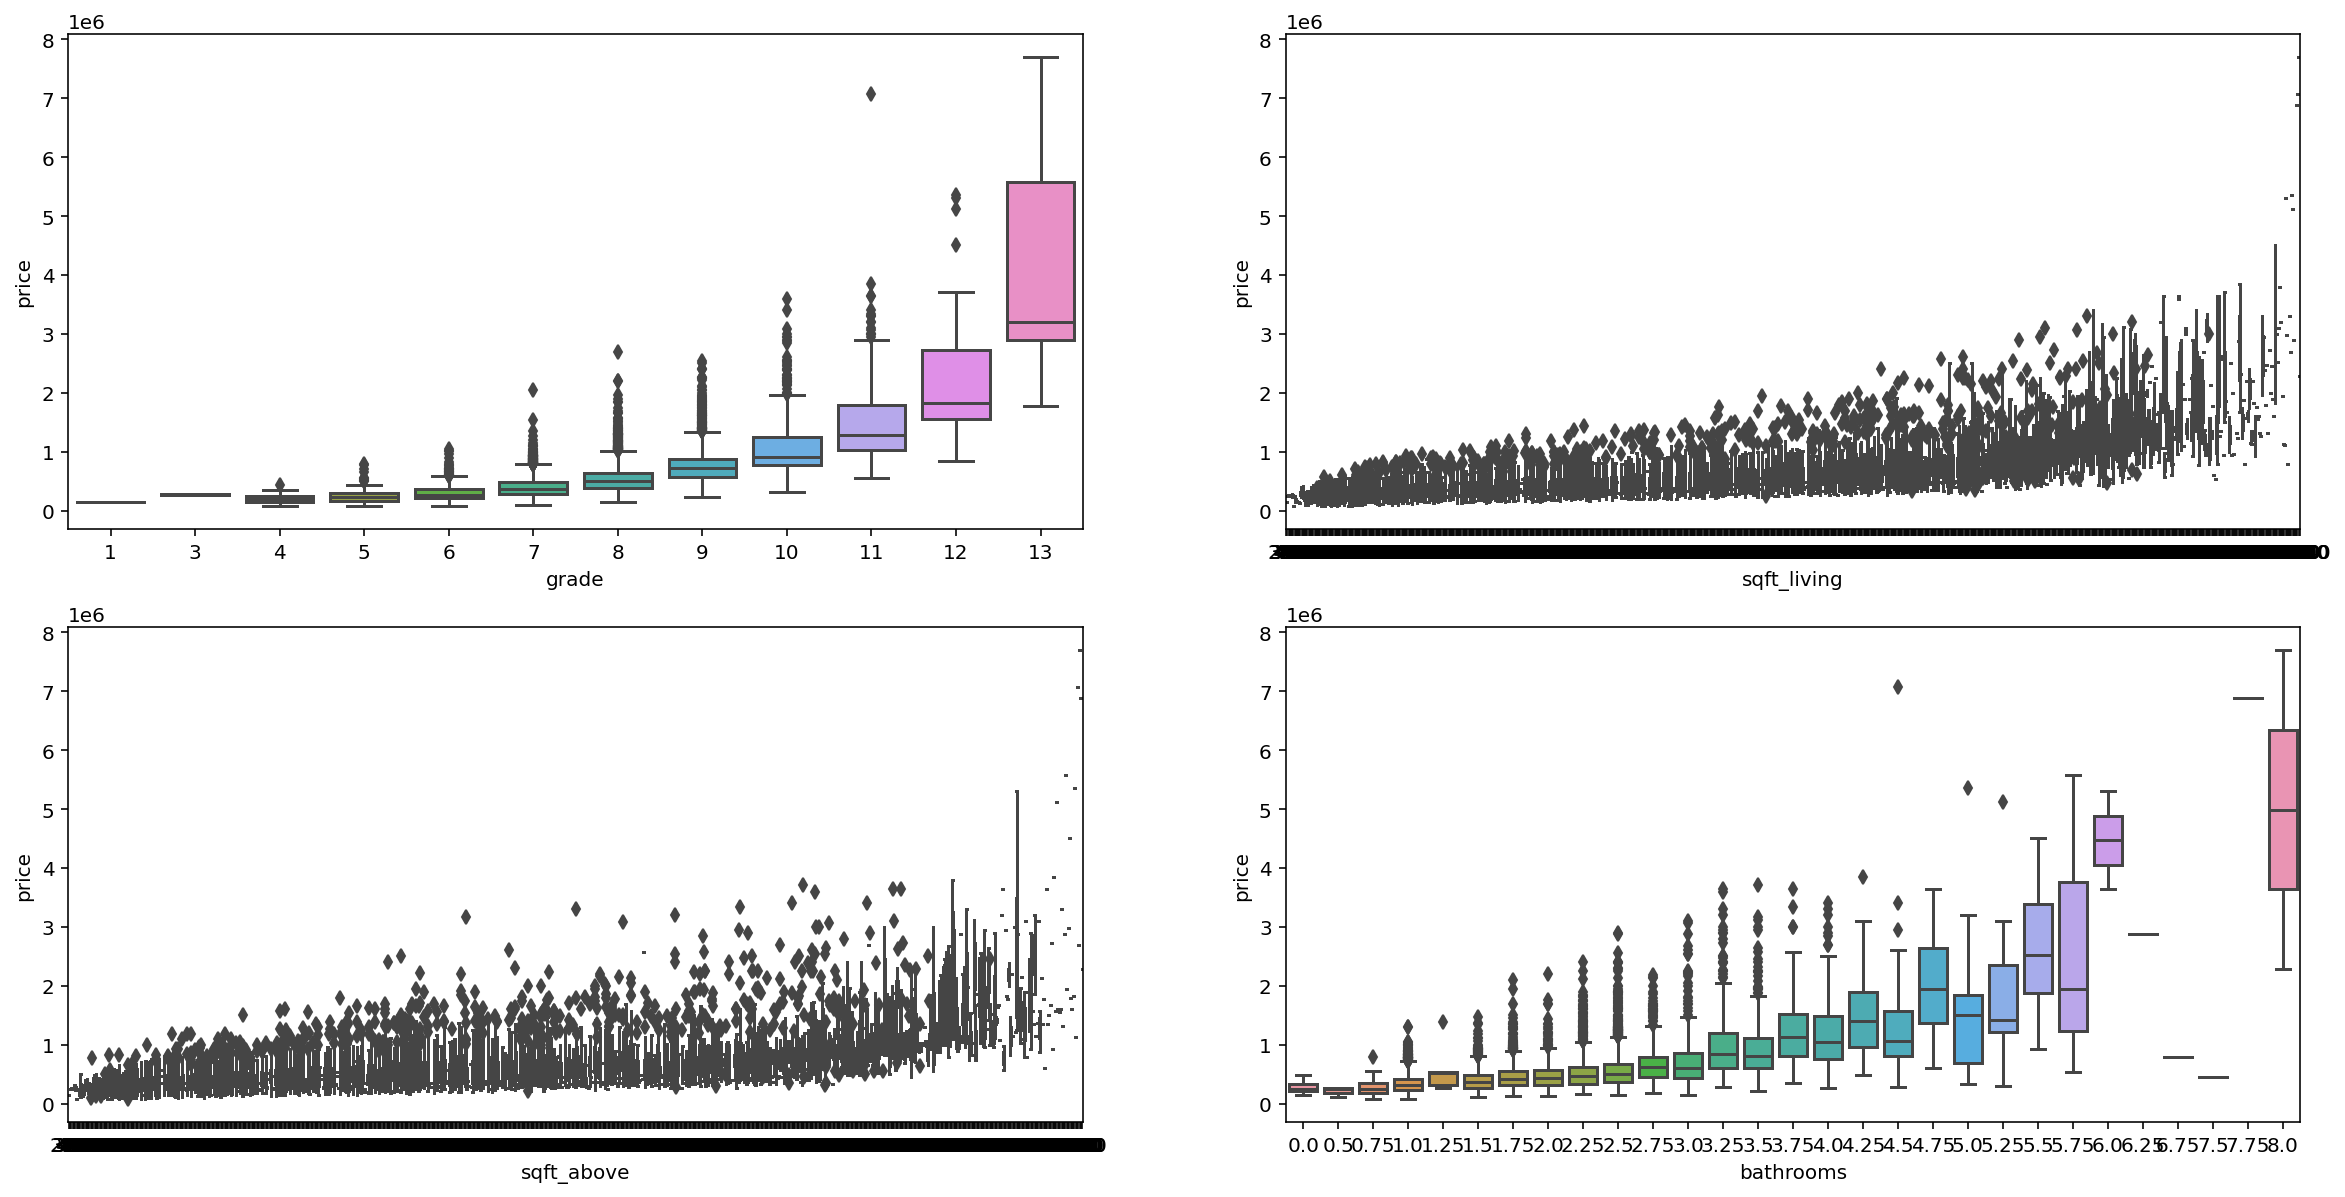

In [44]:
# 위에서 위치는 확인했으니, 나머지 상관계수들의 여부를 확인해보기 위해 boxplot 생성
f, ax =  plt.subplots(2,2, figsize=(15, 10))

# 각각 상관계수가 높았던 grade, sqft_living, sqft_above, bothrooms 순서
sns.boxplot(x='grade', y='price', data=data, ax=ax[0,0])
sns.boxplot(x='sqft_living', y='price', data=data, ax=ax[0,1])
sns.boxplot(x='sqft_above', y='price', data=data, ax=ax[1,0])
sns.boxplot(x='bathrooms', y='price', data=data, ax=ax[1,1])

* [ grade ]는 주택에 따른 등급이라고 해서, 외관상의 디자인을 의미한다고 하는데, 특히 등급 7~ 11 부근에 이상치들이 밀집된 것을 확인할 수 있었다. 특히 11부근의 엄청 크게 올라와 있는 저 점이 굉장히 신경쓰였다....... 데이터를 제외시켜야 한다면 저런 데이터가 아닐까 싶다.

* [ bathrooms ]은 화장실의 여부인데, 개인적으로 저 소숫점이 왜 저렇게 나오는지가 굉장히 궁금했다. 이것도 다른 분들의 캐글을 뒤져보면서 알게된 건데, 개인적으로 미국의 주거공간에 대한 구조 정보를 사전에 다 알지 못해서 정보적인 차이가 생긴 것 같다. 대충 소숫점마다의 특징은 아래와 같다. 

    1. 0.5 : 세면대, 화장실
    2. 0.75 : 세면대, 화장실, 샤워실
    3. 1 : 세면대, 화장실, 샤워실, 욕조

1이면 다 존재하는거, 2면 다 존재하는 화장실이 2개 인 식으로 카운팅된다는걸 한참의 설명을 보고서야 깨달았다.... 여기서 미뤄봤을때, 가장 눈에 띄는 데이터는 4. 54 부근에 있는 엄청난 위치의 아웃라이어였다. bathrooms에서 제외시켜야 한다면 필히 저 데이터가 우선 순위일 것이다. 그 외에도 뒷부분에 연이어 점 하나씩이 올라와 있는 게 눈에 띈다. 

* [ sqft_living ]과 [ sqft_above ]는 정확히 데이터가 산출될만한 시각화가 나오지 않았기 때문에 아래에서 다시 돌려보기로 한다.

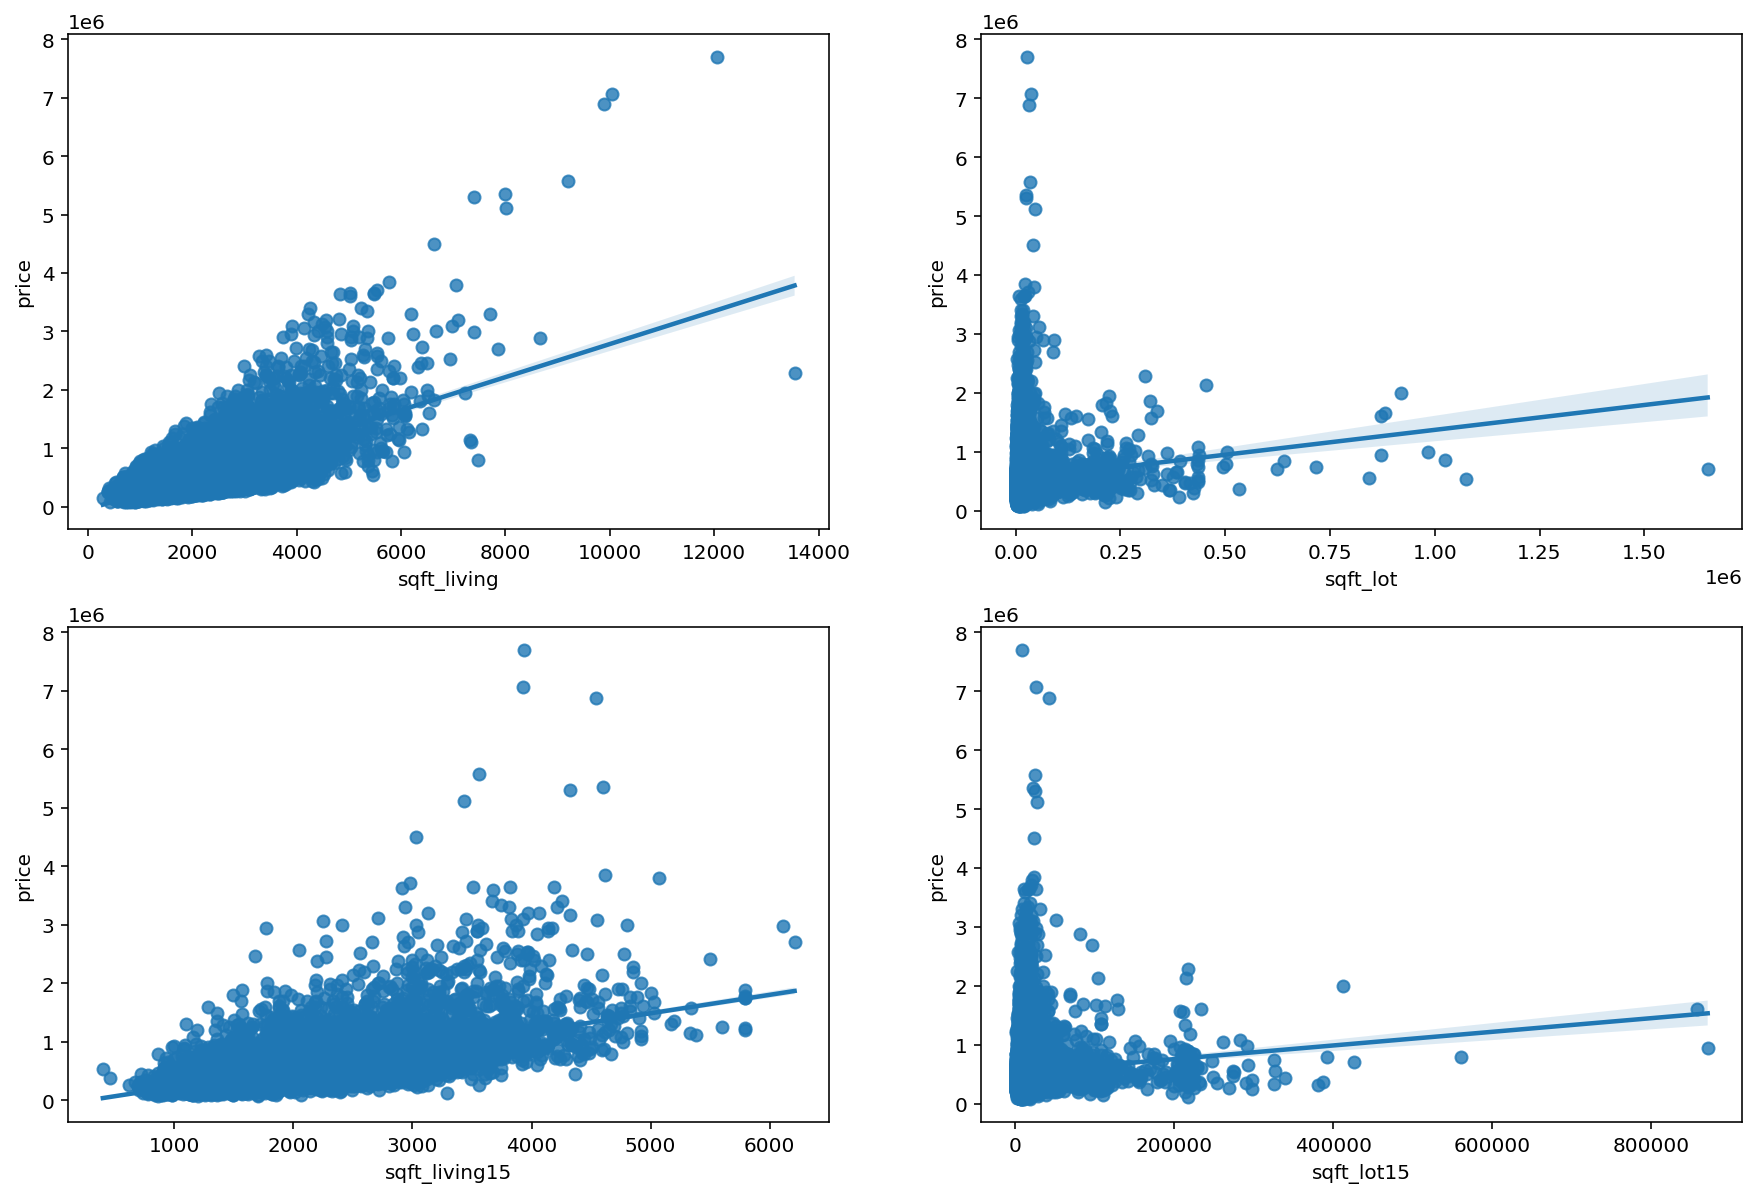

In [54]:
# sqft_living, sqft_living15에 연관된 아웃라이어 찾기
f, ax = plt.subplots(2, 2, figsize=(15, 10))

# 순서대로 sqft_living, sqft_lot, sqft_living15, sqft_lot15 순으로 산점도를 같이 돌려보기
fig_3 = sns.regplot(x='sqft_living', y='price', data=data, ax=ax[0][0])
fig_4 = sns.regplot(x='sqft_lot', y='price', data=data, ax=ax[0][1])
fig_1 = sns.regplot(x='sqft_living15', y='price', data=data, ax=ax[1][0])
fig_2 = sns.regplot(x='sqft_lot15', y='price', data=data, ax=ax[1][1])

* [ sqft_living ]의 경우 선형으로 증가하는 걸 확인할 수 있는데, 이는 면적이 넓어질수록 가격 역시 올라간다는 반증이다. 하지만 오롯이 선을 따라 올라가는게 아닌, 점차 값이 분산되는 것을 확인할 수 있다. 게다가 아이러니 했던건 [ sqft_lot ]의 경우 부지 면적을 말하는건데, 좁은 곳의 값을 더 쳐주는 경우도 있는 모양이다. 따라서 이는 정확한 연관성을 찾기 힘들어보였다.

* [ sqft_living15 ]는 2015년 기준 주거 공간의 평방 피트 값이고, [ sqft_lot15 ]는 2015년 기준 부지 면적 값을 의미한다고 되어 있었다. 확실히 앞서 본 sqft_living 보다는 좀 더 선형에 가까운 분포를 보여주는 것을 볼 수 있다.

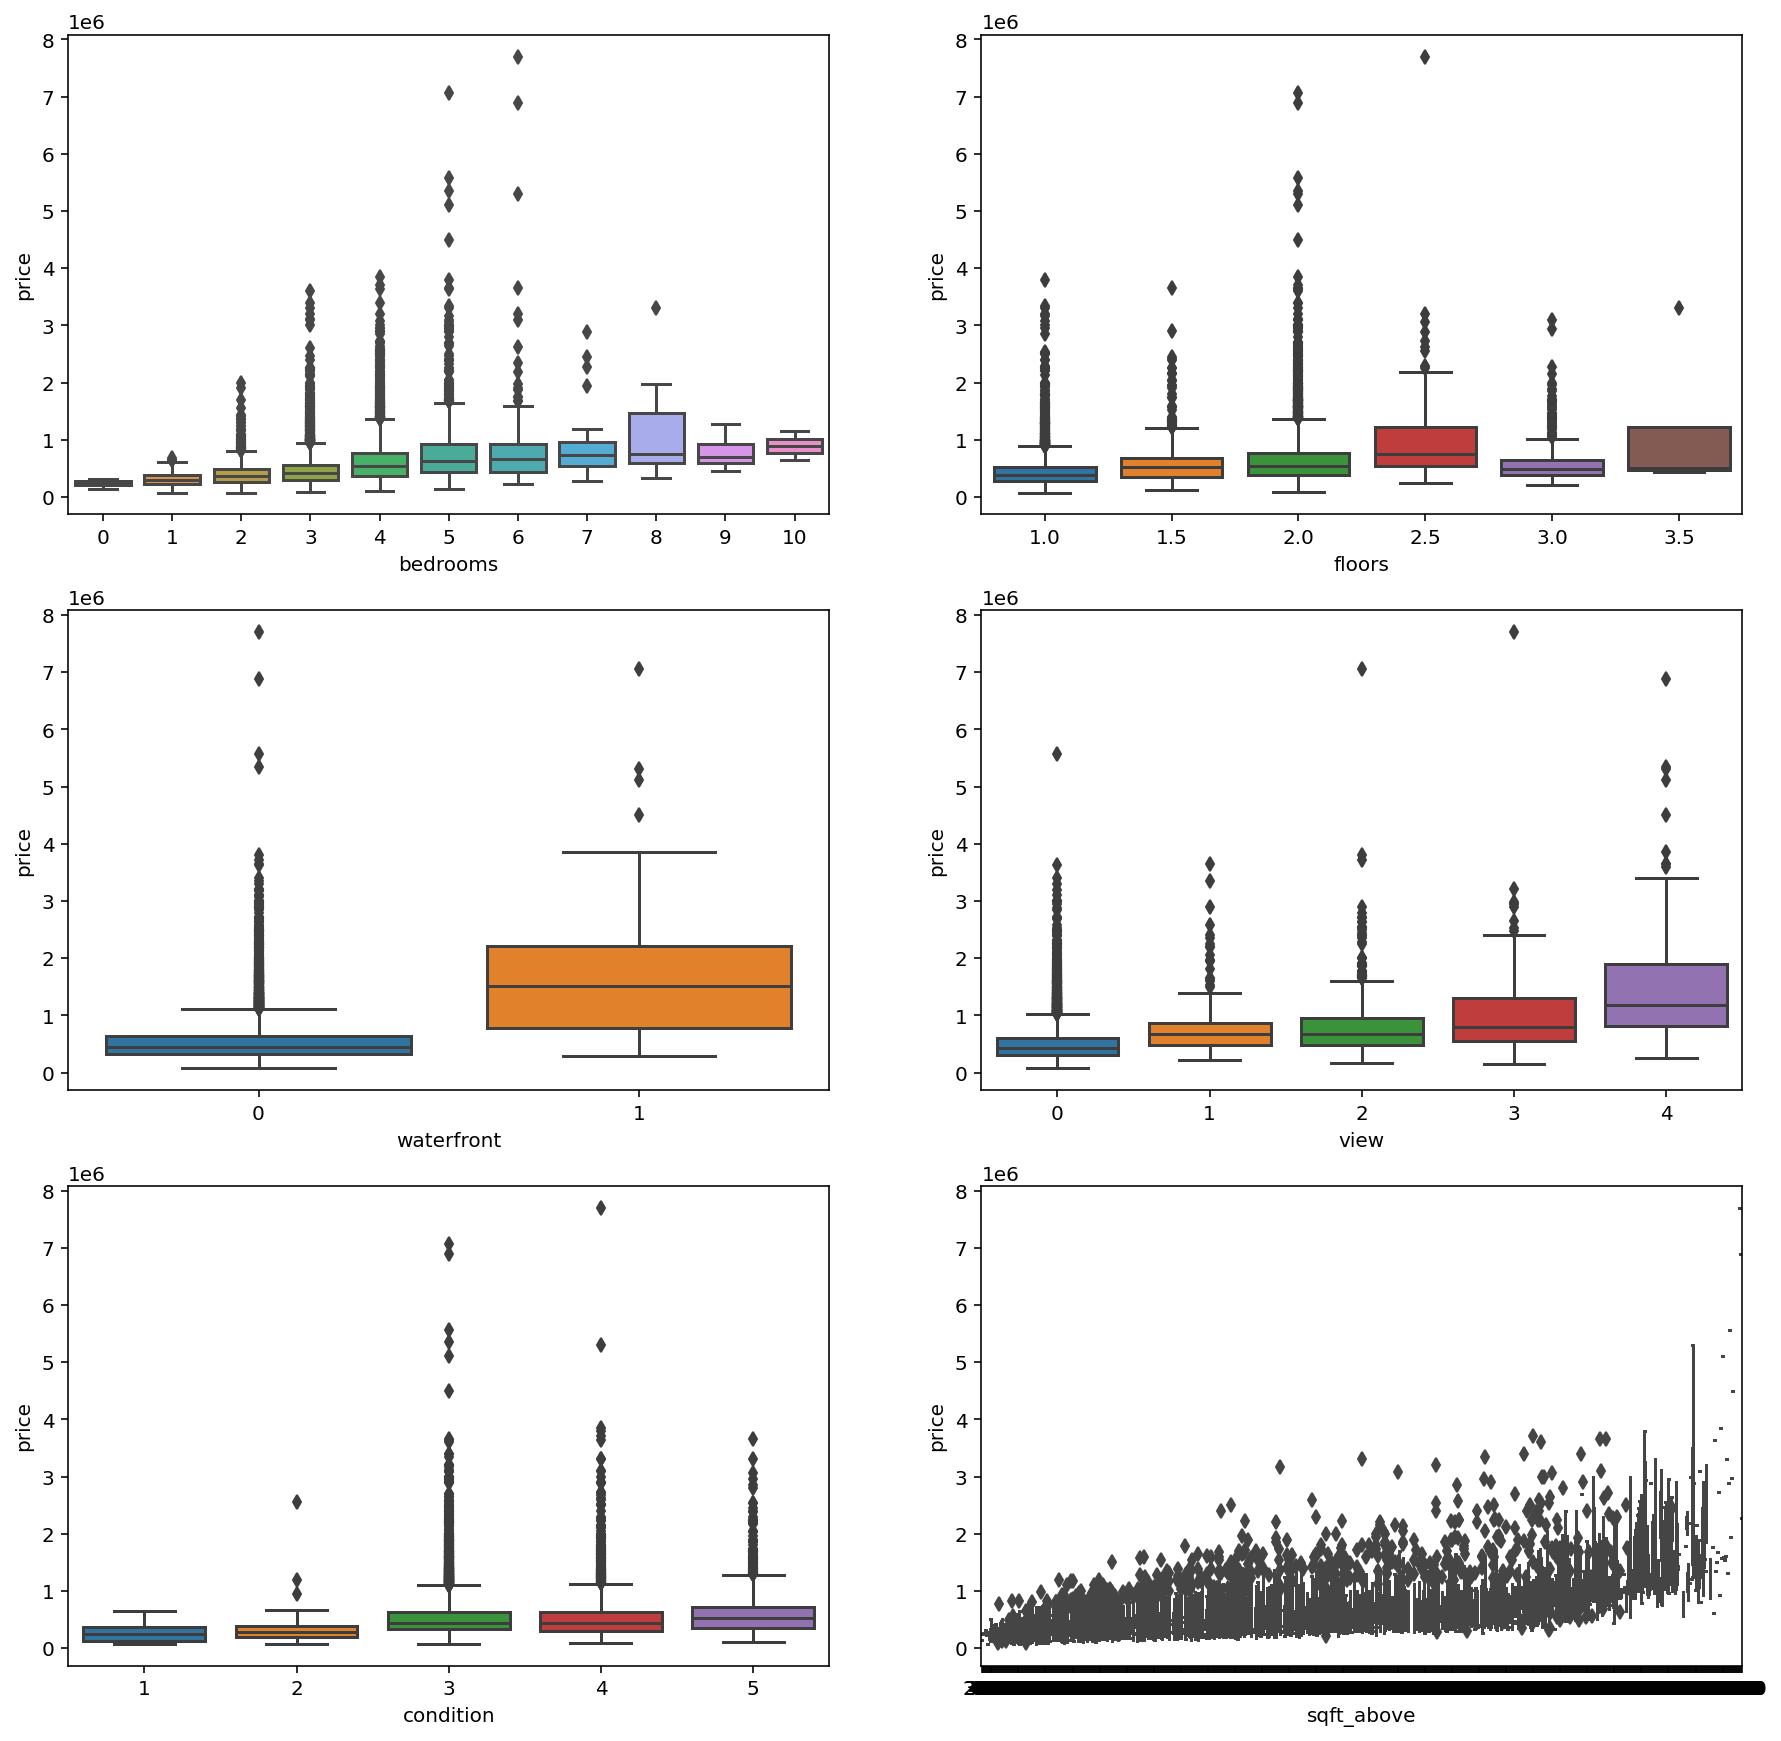

In [66]:
# 나머지 feature값과 price 상관계수와 아웃라이어를 체크하기
f, ax =  plt.subplots(3,2, figsize=(15, 15))

# bedrooms, floors, waterfront, view, condition, sqft_above 순서로 박스 플롯 생성
sns.boxplot(x='bedrooms', y='price', data=data, ax=ax[0,0])
sns.boxplot(x='floors', y='price', data=data, ax=ax[0,1])
sns.boxplot(x='waterfront', y='price', data=data, ax=ax[1,0])
sns.boxplot(x='view', y='price', data=data, ax=ax[1,1])
sns.boxplot(x='condition', y='price', data=data, ax=ax[2,0])
sns.boxplot(x='sqft_above', y='price', data=data, ax=ax[2,1])

* [ bedrooms ]의 경우 int 값이 뚜렷하게 나와있어서 깔끔한 모양을 보여줬는데, 다른 분들도 그냥 침실의 갯수 정도로 생가하면 된다고 전체적인 의견이 일치되는 걸 볼 수 있었다. 어기서는 특히 방 5개, 6개에서 엄청난 아웃라이어가 튀어나왔다.

* [ floors ]는 정확히 말하자면 집이 몇층인지 정도를 표기해주는 정보로 예상했는데, 소숫점인 이유는 따로 다락방이 존재하거나, 또는 1층 면적 대비 다른 층수의 면적이 그보다 작다면 상대적으로 소숫점이 붙는게 아닌가 추측하게 만들었다. 이 역시 2.0, 2.5에서 확 눈에 띄는 아웃라이어가 보였다.

* [ waterfront ]와 [ view ]의 경우는 비슷하지만 조금 다른 feature인데 물이 보이는 경우는 waterfront가 1, 아니면 0의 간단한 구조였고 전망이 얼마나 좋은지에 따라 view를 점수로 나누고 있었다. 여기도 평균적으로 뷰가 좋을수록, 물이 잘 보일수록 좊은 가격대가 형성된 것이 보이지만, 그 차이를 상회하는 집값들이 눈에 띈다.

* [ condition ]은 집이 얼마나 노후되었는지, 깨끗하거나 살만한지의 컨디션을 정수로 표기한게 아닐까 짐작했다. 이역시 1이나 2보다는 5가 소폭 더 높은 집값이 형성되어 있음을 확인했지만, 특히 3과 4 지점에서 확 튀는 아웃라이어 값이 보였다.

* [ sqft_above ]지하실을 제외한 지상의 평방 피트인데, 앞서 다른 부지들을 표기한 데이터값이랑 비슷하게 나왔으므로 따로 다루지 않는다.

= 몇몇 특정 집값이 기본적인 편차보다 엄청 높게 형성된 경우는 위의 위치와 같이 미루어 볼 때, '작아도 위치상 집값이 높은 지역' 과 더불어 '엄청나게 넓어서 비싸게 형성된 집'과 15년도 이후에 수리하거나 개조함으로서 집값이 확 뛰어 이상치에 들 경우 정도를 꼽을 수 있었다. 개인적으로 이런 아웃라이어들을 각기 어떻게 처리하는지 봤는데 대개는 한 두개 정도만 제외하거나, 아니면 아예 제외하지 않는 경우들을 보고 고심 끝에 이상치를 제외하지 않고 모델을 그대로 구축하기로 결정했다.

#### 2. 다양한 실험을 위해 함수로 만들어 쓰자

In [82]:
# 모듈 로드
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 모델 로드
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [83]:
# RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [87]:
# random_state 초기값을 지정해두고 동일하게 모델들을 세팅
random_state=2020 # 원래 random_state=None 이 초기값이지만 고정값을 세팅       

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest] #각각의 모델을 리스트에 넣어준다

In [ ]:
# 각 모델별로 학습과 예측이 가능한 함수를 생성
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

[15:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131589.483559
GradientBoostingRegressor,127799.935212
RandomForestRegressor,126356.911711
LGBMRegressor,111741.684999


* WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

경고문 하나가 나오는게 굉장히 신경쓰이는데.......

![20220505214404](https://user-images.githubusercontent.com/100528803/166925510-f64ee450-9921-4760-8b92-448b92197422.png)

...라고 해서 별다른 에러가 아니므로 패스하기로 한다. ( 결국 나중에는 따로 하이퍼 파라미터를 넣어서 경고문을 안뜨게 만들어 버렸다. 이 과정까지가 좀 괴로웠던 기억이.....)

### R-2. 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도 후 최적의 조합 찾기
-----
#### 3. 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [85]:
# 그리드 탐색 모듈 가져오기
from sklearn.model_selection import GridSearchCV

In [88]:
# GridSearchCV 사용하기 (기본값 따로 빼둔 거)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

* GridSearchCV의 입력 인자들

1. param_grid: 탐색할 파라미터 종류(딕셔너리 형태로 입력)
2. scoring: 모델 성능 평가 지표
3. cv: cross validation(교차 검증)을 위해 train 데이터셋을 나누는 조각의 갯수
4. verbose: 그리드 탐색을 진행하며 과정을 출력해 보여줄 메세지 양(숫자가 크면 더 많이)
5. n_jobs: 그리드 탐색을 진행하며 사용할 CPU갯수

In [89]:
# 첫 모델은 LGBM(LightGBM)
model = LGBMRegressor(random_state=random_state)

In [90]:
# Gridsearch모델 초기화 ~ RMSLE 값이 낮은 순으로 정렬되는 함수 생성
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

In [91]:
# 중간에 feature 값이 하나 안맞아 모델을 돌리기 힘든 상황이 생겨서 id 맨 앞에 값을 삭제한 상태(설정을 잘못했는지 자꾸 생기는 모양)
train = train.drop(['id'], axis=1)
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [92]:
#test 에서의 feature값이 동일한 걸 확인하고 다시 모델을 돌림

test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [ ]:
# 그리드 탐색 실행
param_grid = {
    #'boosting'
    'n_estimators': [100,500,1000],
    'max_depth': [5,10,15],
    #'learning late'
    #'min_samples_split'
    #'max_features'
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,RMSLE
4,10,500,-0.161928,0.161928
7,15,500,-0.162449,0.162449
1,5,500,-0.162603,0.162603
5,10,1000,-0.163447,0.163447
2,5,1000,-0.163843,0.163843
8,15,1000,-0.164114,0.164114
3,10,100,-0.164342,0.164342
6,15,100,-0.164785,0.164785
0,5,100,-0.169647,0.169647


* 'n_estimators'가 [ 100, 500, 1000 ]이고 'max_depth'가 [ 5, 10, 15 ]인 경우만을 놓고 봤을때, 이 변수들 중에서 가장 작은 값을 도출한건 'max_depth'가 [ 10 ]이고 'm_estimators' 가 [ 500 ]일 경우일 때였다.

* LMS 상에서 파라미터 세팅들을 보고 호기심이 생겨서 캐글 상위권에 있는 분은 어떻게 파라미터를 잡는지 궁금해서 찾아봤는데, lightgbm 모델을 이용해서 튜닝한 파라미터 수를 보고 놀랐다..... 총 16개가 쓰였는데 이걸 능숙하게 어떻게 쓸지를 탐구하는 것도 지금의 내가 배워야할 과정임을 깨달았다.......



```
random_state=1028
param = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 5,
    "min_data_in_leaf": 5,
    "bagging_freq": 5,
    "learning_rate" : 0.01,
    "bagging_fraction" : 0.464,
    "feature_fraction" : 0.582,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "verbosity" : 1,
    "feature_fraction_seed" : random_state,
    "bagging_fraction_seed" : random_state,
    "random_state": random_state
}   
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state=1028)
```



* 상위권 다른 한분의 lgbm 파라미터도 살펴봤는데, 각각 값을 달리해서 같은 모델에서 3종류씩의 값을 따로 설정해서 돌리는 것도 확인할 수 있었다. (나중에 보니 이분은 모델 13개씩인가를 돌렸는데 데이터에 따라 값을 다르게 하는건지의 디테일은 좀 더 코드를 읽어봐야 알 것 같다....)


```
lgb_param3 = {
        'objective': 'regression',
        'learning_rate': 0.01,
        'max_depth': 3,
        'num_leaves': 7,
        'min_data_in_leaf': 30,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.2,
        'seed': RANDOM_SEED,
        'metric': ['rmse'],
    }
```



* 신경쓸만한 파라미터들 정리

1. max_depth : Tree의 최대 깊이
2. min_data_in_leaf : Leaf가 가지고 있는 최소한의 레코드 수(디폴트 20)
3. feature_fraction : Boosting (나중에 다뤄질 것입니다) 이 랜덤 포레스트일 경우 사용
4. bagging_fraction : 매번 iteration을 돌 때 사용(트레이닝 속도를 높이고 과적합을 방지할 때)
5. early_stopping_round : 분석 속도를 높이는데 도움
6. lambda : regularization 정규화를 합니다. (일반적인 범위는 0 에서 1 사이)
7. min_gain_to_split :  Tree에서 유용한 분기의 수를 컨트롤하는데 사용

* 핵심 파라미터

1. Task : 데이터에 대해서 수행하고자 하는 임무를 구체화
2. application : 모델의 어플리케이션을 정함(Light GBM에서 디폴트는 regression 회귀분석)
    <br> - regression, binary, multiclass
3. boosting : 실행하고자 하는 알고리즘 타입을 정의
    <br> - gbdt, rf, dart, goss
4. learning_rate : 학습 파라미터, 변화의 크기를 컨트롤(일반적인 값은 0.1, 0.001, 0.003)
5. num_leaves : 전체 Tree의 leave 수 이고, 디폴트값은 31
6. device : 디폴트 값은 cpu 인데 gpu로 변경 가능



#### 3-1. RandomSearch의 사용

In [93]:
#gridsearch가 너무 오래 걸려서 다른 방법을 찾다가 randomsearch를 같이 찾았다....
from sklearn.model_selection import RandomizedSearchCV

* 다만 gridsearch는 param_grid 였는데, RandomSearch의 경우 param_distributions을 쓴다는 걸 나중에 깨달아서 고생했다......

In [94]:
#앞의 GridSearch를 응용해서 RandomSearch 함수를 새로 생성
def my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5):
    
    # RandomizedSearchCV 모델로 초기화
    random_model = RandomizedSearchCV(model,
                             param_distributions=param_distributions,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             verbose=verbose,
                             n_jobs=n_jobs)
    random_model.fit(train, y)

    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# 위의 파라미터를 이용해서 다시 재정의
model = LGBMRegressor(random_state=random_state)

# LGBMRegressor
param_distributions = {
    'max_depth': [10, 15],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [700, 500],
    'num_leavevs':[10, 30]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,num_leavevs,n_estimators,max_depth,learning_rate,score,RMSLE
0,30,700,10,0.05,-0.025881,0.160877
7,10,700,10,0.05,-0.025881,0.160877
3,30,700,15,0.05,-0.025925,0.161013
9,10,700,15,0.05,-0.025925,0.161013
5,30,500,10,0.05,-0.025927,0.161020
8,10,500,10,0.05,-0.025927,0.161020
1,30,500,10,0.10,-0.026245,0.162004
2,10,500,15,0.10,-0.026413,0.162521
4,30,500,15,0.10,-0.026413,0.162521
6,10,700,15,0.10,-0.026642,0.163224


* LGBMRegressor의 파라미터를 조정한 결과,
<br>
learning_rate[0.05], max_depth[10], n_estimators[700], num_leaves[30] 일 때 최적의 RMSLE가 나왔음을 확인할 수 있다.

In [ ]:
# XGBRegressor
param_distributions = {
    'learning_rate':[0.02, 0.1], 
    'n_estimators':[500], 
    'max_depth':[3, 6], 
    'silent':[1], 
    'verbosity':[0]
}

xgb_model = XGBRegressor(random_state=random_state)
my_RandomSearch(xgb_model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,verbosity,silent,n_estimators,max_depth,learning_rate,score,RMSLE
3,0,1,500,6,0.10,-0.026315,0.162220
1,0,1,500,6,0.02,-0.027424,0.165603
2,0,1,500,3,0.10,-0.027686,0.166392
0,0,1,500,3,0.02,-0.033661,0.183470


* XGBRegressor의 파라미터를 조절한 결과,
<br>learning_rate[0.10], max_depth[6], n_estimators[500]에서 최적값이 나왔다.

* WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

> 위의 오류가 나서 verbosity = 0, silent=True 를 추가

In [ ]:
# RandomForestRegressor
# 너무 느렸기 때문에 gridSearch 돌렸던 그대로 놔뒀다.....

param_grid = {
        'n_estimators': [500, 100],
        'max_depth': [3, 5],
        'max_features': [1.0],
        'n_jobs': [-1],
        'random_state': [0]
}

rf_model = RandomForestRegressor(random_state=random_state)
my_GridSearch(rf_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,max_features,n_estimators,n_jobs,random_state,score,RMSLE
3,5,1.0,100,-1,0,-0.241191,0.241191
2,5,1.0,500,-1,0,-0.241274,0.241274
1,3,1.0,100,-1,0,-0.292122,0.292122
0,3,1.0,500,-1,0,-0.292173,0.292173


In [97]:
# 이건 캐글 유저분이 뽑아낸 코드인데, 점수가 어느정도 나오나 궁금해서 돌려봤더니..... 훨씬 RMSLE값이 단축된걸 확인했다..
# RandomForestRegressor
RANDOM_SEED = 42

param_grid = {
        'n_estimators': [1000],
        'max_depth': [20],
        'max_features': [0.6],
        'n_jobs': [-1],
        'random_state': [RANDOM_SEED]
}

rf_model = RandomForestRegressor(random_state=random_state)
my_GridSearch(rf_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,max_depth,max_features,n_estimators,n_jobs,random_state,score,RMSLE
0,20,0.6,1000,-1,42,-0.175059,0.175059


* RandomForestRegressor의 파라미터를 조절한 결과는 너무 느렸는데, 상위권 분의 파라미터를 같이 참조한 결과
<br>max_depth[20], max_features[0.6], n_estimators[1000], n_jobs[-1], random_state[42]에서 최적값이 나왔다.
하지만 xgboost와 lgbm과 견주어 볼때 최적치는 아니었다.

In [ ]:
# GradientBoostingRegressor

param_grid = {
        'n_estimators': [500, 700],
        'learning_rate': [0.1],
        'max_depth': [5],
        'subsample': [0.7],
        'max_features': [0.6, 1.0],
        'random_state': [0]
    }

gbr_model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(gbr_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,max_features,n_estimators,random_state,subsample,score,RMSLE
0,0.1,5,0.6,500,0,0.7,-0.163123,0.163123
1,0.1,5,0.6,700,0,0.7,-0.163707,0.163707
2,0.1,5,1.0,500,0,0.7,-0.164131,0.164131
3,0.1,5,1.0,700,0,0.7,-0.164601,0.164601


* GradientBoostingRegressor의 파라미터를 조절한 결과,
<br>learning_rate[0.1], max_depth[5], max_features[0.6], n_estimators[500], random_state[0], subsample[0.7] 에서 최적값이 나왔다.

In [98]:
# 이건 캐글에서 상위 유저분이 쓰신 파라미터 값인데 얼마나 성능이 나오는지 그냥 궁금해서 돌려봄
# GradientBoostingRegressor
RANDOM_SEED = 42

param_grid = {
        'n_estimators': [1000],
        'learning_rate': [0.1],
        'max_depth': [2],
        'subsample': [0.7],
        'max_features': [0.6],
        'random_state': [RANDOM_SEED]
    }

gbr_model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(gbr_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,learning_rate,max_depth,max_features,n_estimators,random_state,subsample,score,RMSLE
0,0.1,2,0.6,1000,42,0.7,-0.168171,0.168171


* 이 경우 위에서 내가 직접 조절한 RMSLE 값이 더 적게 나왔기 때문에 그냥 내가 조절했던 하이퍼 파라미터 내에서 사용하기로 결정했다.

### R3. 세가지 이상의 다양한 모델에 하이퍼 파라미터 튜닝
-----

* 개인적으로 여기서 함수를 써서 통합시킬까 했는데, 각각의 파라미터를 직접 복붙하면서 계속 건드리다보니 결국 그냥 이대로 진행했다.... 좀 더 익숙해지면 도전해보는 걸로..

In [99]:
# 위에서 파라미터를 뽑아낸 모델들 중에서 제일 최적의 값을 뽑은 모델 값을 대입

# LGBM의 파라미터를 이용해서 추출했다.
lgbm_model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=30, random_state=RANDOM_SEED)
lgbm_model.fit(train, y)

LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=30,
              random_state=42)

In [100]:
# LGBM을 로그값에서 원래 값으로 전환
lgbm_p = lgbm_model.predict(test)
lgbm_p = np.expm1(lgbm_p)
lgbm_p

array([ 488684.48256796,  478240.54181746, 1326249.58990369, ...,
        490074.31424665,  331712.6914091 ,  438592.29314962])

In [101]:
# XGBRegressor 모델에서 가져온 최적의 파라미터를 적용 
xgb_model = XGBRegressor(learning_rate=0.10, max_depth=6, n_estimators=500, verbosity=0, silent=True, random_state=RANDOM_SEED)
xgb_model.fit(train, y)

XGBRegressor(max_depth=6, n_estimators=500, random_state=42, silent=True,
             verbosity=0)

In [102]:
# XGB 수치를 로그값에서 원래 값으로 전환
xgb_p = xgb_model.predict(test)
xgb_p = np.expm1(xgb_p)
xgb_p

array([ 540847.44,  418383.3 , 1344215.  , ...,  475993.28,  330608.28,
        460668.78], dtype=float32)

In [109]:
# GBR 모델에서 가져온 최적의 파라미터를 적용 
gbr_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, max_features=0.6, n_estimators=500, subsample=0.7, random_state=RANDOM_SEED)
gbr_model.fit(train, y)

GradientBoostingRegressor(max_depth=5, max_features=0.6, n_estimators=500,
                          random_state=42, subsample=0.7)

In [110]:
# GBR 수치를 로그값에서 원래 값으로 전환
gbr_p = gbr_model.predict(test)
gbr_p = np.expm1(gbr_p)
gbr_p

array([ 554997.98018553,  450214.42513318, 1328976.03137069, ...,
        484285.05036064,  310589.40416526,  442369.39019903])

In [111]:
# RF 모델에서 가져온 최적의 파라미터를 적용 
rf_model = RandomForestRegressor(max_depth=20, max_features=0.6, n_estimators=1000, n_jobs=-1, random_state=RANDOM_SEED)
rf_model.fit(train, y)

RandomForestRegressor(max_depth=20, max_features=0.6, n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [112]:
# RF 수치를 로그값에서 원래 값으로 전환
rf_p = rf_model.predict(test)
rf_p = np.expm1(rf_p)
rf_p

array([ 487331.99835524,  471789.93012254, 1284821.83171913, ...,
        459407.65322912,  329623.50492234,  435932.0217857 ])

#### - 각각의 단일 모델 성능 평가

![20220507224806](https://user-images.githubusercontent.com/100528803/167257847-aecbc6b8-b0ba-42f0-a240-15e2506e726c.png)

In [164]:
model_score = {'Model':['XGBRegressor', 'LGBMRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor'],
               'Public Score':[108045, 112214, 112809, 134536]}

df = pd.DataFrame(model_score)
df

,Model,Public Score
0,XGBRegressor,108045
1,LGBMRegressor,112214
2,GradientBoostingRegressor,112809
3,RandomForestRegressor,134536


* 파라미터를 조절해서 나왔던 걸로는 [ XGBRegressor ]모델의 성능이 가장 좋았고, 뒤이어 [ LGBMRegressor ], [ GradientBoostingRegressor ], [ RandomForestRegressor ]순이었다. 루브릭의 기준이 퍼블릭 스코어였는데, 11만 이하의 스코어에 충족되는 모델은 XGB모델 하나였다.

* 사실 XGB 모델보다 RMSLE 성능이 더 좋은 모델도 존재했는디(LGBM이라던가....)왜 가장 선두로 앞서는지를 곰곰히 생각해보니 아무래도 random_state의 여부가 아닌가 짐작했다. random_seed일때와 아닐때의 차이가 있나 싶었는데 의외로 별로 다른게 없기도 하고 알쏭달쏭하다.

### R4. Baseline 커널에서 활용된 블렌딩 방법 활용
-----

베이스라인 커널에서는 위 코드에서와 같이 'AveragingBlending'을 쓰는데, 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용되는 앙상블 기법이다. 다른 캐글 코드들을 보다가 이걸 np.vstack으로 한번 모델들의 값을 합친 후에 .mean으로 평균을 낸다는게 신박해서 앞서 나온 함수보다 짧은 코드 한줄로 대체하게 되었다. 대체 이런 건 어떻게 생각하는거지......

#### - 2개의 모델(LGBM, XGB)로 앙상블 모델 만들기

In [138]:
# 하나의 값만으로는 도저히 private 11만 이하를 달성할 수 없어서, 가장 최소값이 나온 두 모델로 앙상블 만들기
ensemble_p2 = np.vstack([lgbm_p, xgb_p]).mean(0)

#### - 3개의 모델(LGBM, XGB, GBR)로 앙상블 모델 만들기

In [130]:
# 3개의 모델로 앙상블 만들기
ensemble_p3 = np.vstack([lgbm_p, xgb_p, gbr_p]).mean(0)

#### - 4개의 모델(LGBM, XGB, GBR, RF)로 앙상블 모델 만들기

In [139]:
# 4개의 모델로 앙상블 만들기
ensemble_p4 = np.vstack([lgbm_p, xgb_p, gbr_p, rf_p]).mean(0)

#### - 6개의 모델(LGBM1, LGBM2, LGBM3, XGB, GBR, RF)로 앙상블 모델 만들기

In [124]:
# 여러개의 모델을 위해 lgbm의 버전들을 나눠봄
RANDOM_SEED = 42

# lgbm_1번째(내가 설정한 모델)
lgbm_model_e1 = LGBMRegressor(learning_rate=0.1, max_depth=6, n_estimators=500, random_state=RANDOM_SEED)
lgbm_model_e1.fit(train, y)

LGBMRegressor(max_depth=6, n_estimators=500, random_state=42)

In [126]:
# lgbm_2번째(캐글 상위 유저의 모델1)
lgbm_model_e2 = LGBMRegressor(objective='regression', learning_rate=0.01, max_depth=20, num_leaves=63, min_data_in_leaf=30,
                              bagging_fraction=0.7, bagging_freq=1, feature_fraction=0.2, metric='rmse',
                              random_state=RANDOM_SEED)
lgbm_model_e2.fit(train, y)

LGBMRegressor(bagging_fraction=0.7, bagging_freq=1, feature_fraction=0.2,
              learning_rate=0.01, max_depth=20, metric='rmse',
              min_data_in_leaf=30, num_leaves=63, objective='regression',
              random_state=42)

In [127]:
# lgbm_3번째(캐글 상위 유저의 모델2)
lgbm_model_e3 = LGBMRegressor(objective='regression', learning_rate=0.005, max_depth=20, num_leaves=31, min_data_in_leaf=30,
                              min_child_samples=20, boosting='gbdt', bagging_seed=11, lambda_l1=0.1, verbosity=-1, nthread=4,
                              bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9, metric='rmse',
                              random_state=RANDOM_SEED)
lgbm_model_e3.fit(train, y)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', feature_fraction=0.9, lambda_l1=0.1,
              learning_rate=0.005, max_depth=20, metric='rmse',
              min_data_in_leaf=30, nthread=4, objective='regression',
              random_state=42, verbosity=-1)

* 위 lgbm의 파라미터 값들은 캐글 상위권 분들의 파라미터들의 평균을 보고 조합했습니다.(3개씩 때려넣는 분들이 보여서 어떻게 나오나 실험용으로 조합)

In [128]:
# LGBM 모델들을 로그값에서 원래 값으로 전환

# 앙상블 1번째
lgbm_p1 = lgbm_model_e1.predict(test)
lgbm_p1 = np.expm1(lgbm_p1)
print(lgbm_p1)

# 앙상블 2번째
lgbm_p2 = lgbm_model_e2.predict(test)
lgbm_p2 = np.expm1(lgbm_p2)
print(lgbm_p2)

# 앙상블 3번째
lgbm_p3 = lgbm_model_e3.predict(test)
lgbm_p3 = np.expm1(lgbm_p3)
print(lgbm_p3)

[ 492729.40058665  476385.70846157 1384301.16160561 ...  489298.46123194
  320325.21313294  443107.4998142 ]
[473779.36706802 468232.04933354 804377.38342939 ... 465728.20372902
 399580.09899714 447558.89401991]
[470093.87646092 430905.39484828 693361.71214526 ... 450894.89080085
 440792.50055157 456689.89306867]


In [132]:
# 6개의 모델로 앙상블 만들기
ensemble_p6 = np.vstack([lgbm_p1, lgbm_p2, lgbm_p3, xgb_p, gbr_p, rf_p]).mean(0)

#### - 파일 저장 후 각각의 스코어 확인

In [113]:
# sample_submission을 가져오기
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [144]:
# sample_submission에 price를 모델이 도출한 예측값으로 덮어쓰기
submission['price'] = ensemble_p6 # 여기에 각각의 값들을 돌리면서 넣었다(사실 for문으로 하려다가 모델들 파라미터를 계속 돌려야 해서 포기....)
submission.head()

,id,price
0,15035,5.032967e+05
1,15036,4.526518e+05
2,15037,1.140009e+06
3,15038,3.254445e+05
4,15039,3.505293e+05


In [145]:
# 'submission.csv'로 해당 내용을 저장
submission.to_csv('submission.csv', index=False) # 여기서 이름을 계속 바꿔가면서 저장

In [146]:
!ls # 각각 버전별로 submission 파일을 생성했음을 확인

ensemble_p2_submission.csv  gbr_submission.csv	 sample_submission.csv
ensemble_p3_submission.csv  lgbm_submission.csv  test.csv
ensemble_p4_submission.csv  rf_submission.csv	 train.csv
ensemble_p6_submission.csv  sample_data		 xgb_submission.csv


In [ ]:
#파일 다운받아서 값을 확인

# 단일 모델
files.download('gbr_submission.csv')
files.download('lgbm_submission.csv')
files.download('rf_submission.csv')
files.download('xgb_submission.csv')

# 앙상블 모델
files.download('ensemble_p2_submission.csv')
files.download('ensemble_p3_submission.csv')
files.download('ensemble_p4_submission.csv')
files.download('ensemble_p6_submission.csv')

#### - 전체 앙상블 모델의 평가

![20220507235153](https://user-images.githubusercontent.com/100528803/167259730-b2c1dbae-8a2b-4e66-8102-5fef03787a96.png)

In [168]:
model_score = {'Model':['Ensemble_3(L,X,G)', 'Ensemble_2(L,X)', 'Ensemble_4(L,X,G,R)', 'Ensemble_6(L1,L2,L3,X,G,R)'],
               'Public Score':[107732, 108223, 110668, 155738]}

df = pd.DataFrame(model_score)
df

,Model,Public Score
0,"Ensemble_3(L,X,G)",107732
1,"Ensemble_2(L,X)",108223
2,"Ensemble_4(L,X,G,R)",110668
3,"Ensemble_6(L1,L2,L3,X,G,R)",155738


* Public Score 기준으로는 [ 앙상블 3번 ] 모델이 가장 좋은 속도를 자랑했다. 107732라 퍼블릭 상으로는 가장 낮지만, 앙상블 모델 2번하고 비교해봤을 때 오히려 더 점수가 높은데다가 기본 점수와 퍼블릭 점수의 편차가 더 커보여서 최적의 모델은 [ 앙상블 2번 ]으로 결정했다. 앙상블 모델 중에서 루브릭 기준을 통과한 모델은 [ 앙상블 2번 ]. [ 앙상블 3번 ]의 두 모델이었다.

* 확실히 'RandomForest'가 들어가면 점수가 확연하게 높아진다는 점이었는데, 제일 의아했던 부분은 [ 앙상블 6번 ]모델 이었다. 사실 L2, L3의 데이터가 어떤 수치를 보여주는지가 관건으로 남는데, 속도가 너무 오래걸려서 돌리다가 놓아준게 좀 아깝다.... 만약 익스 노드의 제출 기한이 좀더 여유로웠다면 싹 다 돌려봤을텐데 그게 조금 아쉬움으로 남는다.( 모델 8개 + 파라미터 바꾸는 시간만 좀 적었다면 가능했을 것 같은데..)

#### 4-1. 제출하는 것도, 빠르고 깔끔하게!

![20220506001624](https://user-images.githubusercontent.com/100528803/166956914-d29c8bc9-954f-48d4-9886-0c9c47cd9a0f.png)

* 처음 퍼블릭 스코어 [ 116127 ] >>>> [ 108587 ]로 루브릭 기준인 11만 안으로 들어갔다.

* 사실 앞서 단일 모델이었던 XGB가 퍼블릭 스코어 상으로는 제일 낮긴 한데, 그냥 스코어와 비교했을때를 따진다면 둘 다 11만 안으로 들어오는 걸 선택하는게 좋다고 판단했다. 아무래도 이 점수는 모델의 과적합 여부에 따라 갈리는게 아닌가... 다른 글들을 읽으면서 추측해봤는데, 파라메터를 조절하는 것만으로도 이정도 순위를 높일 수 있다는 건 신기했지만 반대로 지금의 배움으로는 아직 10만 정도의 순위에 머무는 걸로 그치겠구나 싶어서 조금 아쉬웠다.

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

![20220507214933](https://user-images.githubusercontent.com/100528803/167257876-30a80c1b-036f-4a72-b14c-9a314562c787.png)

모델 돌리는 중반까지 장렬하게 까먹고 있었던 GPU.......그리드 서치가 너무 느린 나머지 혹시..? 싶어서 봤다가 None이었던 걸 보고 오열한 기억이 있다. (Pro의 뽕을 뽑기로 하자 꼭 기억하기..)


중간중간 코드를 돌리다가 나오는 에러를 해결하는 건 여전히 까다로우면서도 쉽지 않은 문제였다. 이번에는 특히 파라미터를 넣을 때 왜 이게 안되는지(결국 이건 대괄호로 해결을 봤다...)와 더불어 모델 넣기전 feature 값이 어디서 늘어났는지 서로 train과 test가 일치하지 않아서 애를 먹은 기억도 난다. 그래도 결국 하나씩 해결하는 과정에서 경험치가 조금은 늘어난 것 같다. 

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

이번에는 스스로 생각해서 코드를 짜거나 구글링하기보다는 해당 캐글 코드 란에 파고들어 상위권 분들의 코드를 샅샅이 찾으며 분석했다. 이 사람은 어떤 모델을 썼길래 성적이 잘 나왔고, 그 과정에서 파라미터를 어떻게 썼는지를 중점적으로 보면서 분석하기에 초점을 맞췄는데 갈수록 첩첩산중인 게 느껴졌다. 같은 데이터를 가지고 이토록 다른 관점으로 볼 수 있다는 것도 신기했고, 무엇보다 folium과 geojeson으로 지역 좌표 값을 따서 시각적으로 강력하게 보여줄 수 있다는 점을 다시 확인했다.(folium은 사용해본 적이 있긴 했는데 아직도 코드로 구현해보라고 하면 자신은 없다....)

<br>



![20220507224532](https://user-images.githubusercontent.com/100528803/167260160-e7f81bc7-5709-4bc8-b18a-5251cd36b7c9.png)

- EX노드를 위해 돌린 총 모델의 갯수는 8개(+앙상블 용 3개 추가), 프로토 타입(LMS상의 노드 모델) 2개를 합해서 총 10개의 모델을 만들어 돌렸다. 그 중에서 단일 모델 4개, 앙상블 모델 4개가 최종적인 데이터로 쓰였다.

In [169]:
# 최종 스코어
model_score = {'Model':['Ensemble_3(L,X,G)', 'XGBRegressor', 'Ensemble_2(L,X)', 'Ensemble_4(L,X,G,R)', 'LGBMRegressor', 
                        'GradientBoostingRegressor', 'RandomForestRegressor', 'Ensemble_6(L1,L2,L3,X,G,R)'],
               'Public Score':[107732, 108045, 108223, 110668, 112214, 112809, 134536, 155738]}

df = pd.DataFrame(model_score)
df

,Model,Public Score
0,"Ensemble_3(L,X,G)",107732
1,XGBRegressor,108045
2,"Ensemble_2(L,X)",108223
3,"Ensemble_4(L,X,G,R)",110668
4,LGBMRegressor,112214
5,GradientBoostingRegressor,112809
6,RandomForestRegressor,134536
7,"Ensemble_6(L1,L2,L3,X,G,R)",155738


* 8개의 모델 중에서 루브릭 상에서의 11만을 달성한 모델은 [ 앙상블 3번 ], [ XGBRegressor ], [ 앙상블 2번 ]순서였다.

1. 앙상블 3번 : 각각의 단일모델 LGBMRegressor, XGBRegressor, GradientBoostingRegressor 을 혼합한 모델
2. 단일 모델 : XGBRegressor 하나로만 쓰인 모델
3. 앙상블 2번 : 각각의 단일모델 LGBMRegressor, XGBRegressor

여기서 느낀 점은
- 하이퍼 파라미터 조절은 성능에 매우 중요하다..
- 데이터를 병렬적으로 나눠서 돌리는 건 속도에 매우 중요하다
- 이왕이면 데이터 나누는 기준이 feature를 효율적으로 나눌 수 있는 기준이면 더 좋지 않을까?(실제로 위치 값이나 우편번호를 이용해서 비슷한 지역의 집값만을 도출하는 데이터셋을 보고 감탄했다)
- 모델의 특성에 맞춰서 서로 시너지를 내는 앙상블이 존재할 수 있다.

#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | <br>캐글 데이터분석 전과정이 성공적으로 진행되었는가?<br>                                 | 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.<br>                                                        |
| **2** | <br>전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?<br> | 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이<br><br> 체계적으로 기술되었다.                               |
| **3** | 회귀모델 예측정확도가 기준 이상 높게 나왔는가?                                    | 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해<br><br> 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다. |

![33](https://user-images.githubusercontent.com/100528803/166957402-84421ae1-824b-4eaa-9bc2-3249f89195ea.png)

일단 Private score가 [ 116127 ]에서 [ 108587 ]로 들어왔다는 점에서 루브릭 기준은 간신히 세이프한 걸 그나마 다행으로 치고 싶다. 사실 제일 수치가 좋았던건 LGBM이었는데 단일 모델만으로는 퍼블릭 스코어를 간당간당하게만 맞출 수 있었기 때문에 여러번 돌리면서도 여러모로 애가 탔다. 그러다가 앙상블을 위해 XGB 하나를 더 추가했는데, 하필 XGB 같은 경우는 중간에 에러가 떠서 될 때가 있고 안될 때가 있고 반반이라서 구글링을 정말 오래 했던 기억이 난다........그래도 결국 달성했으니 최선을 다한 걸로..

<br>

#### ▶️ 자기 다짐

이번 EX노드 같은 경우는 파라미터와 모델이 돌아가는 시간 때문에 꼬박이 하루를 통으로 보내게 만들었다. 근데 결국 이게 시작이고 다른 노드들도 점차 난이도가 높아감에 따라 잠이 부족하겠구나....를 절실히 예감하게 만든 계기가 되었다. 흔히 DS쪽에서 데이터를 돌려놓고 잔다는게 무슨 말인지 새삼 알게 된 시간이었다..

<br>

## ✔️Reference(참고자료)
-----
* https://www.kaggle.com/code/tmheo74/geo-data-eda-and-feature-engineering
* https://www.kaggle.com/code/fulrose/eda-with-map-visualization
* https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12
* https://www.kaggle.com/code/tmheo74/11th-solution-public-98316-private-99336
* https://www.kaggle.com/code/hyeonho/hhl-solution
* https://www.kaggle.com/code/harangdev/feature-selection
* https://psystat.tistory.com/131
* https://smecsm.tistory.com/133
* https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
* https://hyemin-kim.github.io/2020/08/04/S-Python-sklearn4/

